# 1. Setup
## 1.1 Imports

In [1]:
import csv
import dill as pickle
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib.patches as patches
import numpy as np
import math
import pandas as pd
import seaborn as sns
import dubins
import os
from copy import copy
from sklearn import preprocessing
import matplotlib.patches as mpatches
import scipy.stats


## 1.2 Function Definitions

In [2]:
def open_csv(base_dir, s_experiment, s_csv, n_scenario, n_iteration):
    f_name = str(base_dir) + str(s_experiment) + "\\S_" + str(n_scenario) + "\\i_" \
        + str(n_iteration) + "\\" + str(s_csv) + "_" + str(n_scenario) + ".csv"
    return open(f_name, newline='')

def open_path(base_dir, s_experiment, n_path, n_scenario, n_iteration):
    f_name = str(base_dir) + str(s_experiment) + "\\S_" + str(n_scenario) + "\\i_" \
        + str(n_iteration) + "\\py_objs\\" + str(n_path) + "_path.po"
    return open(f_name, 'rb')

def exists_csv(base_dir, s_experiment, s_csv, n_scenario, n_iteration):
    f_name = str(base_dir) + str(s_experiment) + "\\S_" + str(n_scenario) + "\\i_" \
        + str(n_iteration) + "\\" + str(s_csv) + "_" + str(n_scenario) + ".csv"
    return os.path.isfile(f_name)

# 2. Create and Plot Reference Paths
## 2.1 Functions

In [3]:
# parameters
turn_radius = 0.3
resolution = math.pi / 64
step_size = 0.05

def create_scenario(way_points, add_end=True):
    if add_end:
        way_points.append((8, 0))
    
    total_l = 0.
    total_p = []
    wp_0 = (0,0,0) # start config
    while len(way_points) > 0:
        # set way points
        wp_1 = way_points[0]
        wp_2 = way_points[1] if len(way_points) > 1 else None
        
        # make dubins path objects
        path_l: [] = dubins.shortest_paths_2(wp_0, wp_1, wp_2, turn_radius, resolution)
        
        # get length
        l = path_l[0].path_length()
        if len(way_points) > 1:
            l += path_l[1].path_length()
        total_l += l
        
        # get path points
        total_p = total_p + path_l[0].sample_many(step_size)[0] 
        if len(way_points) > 1:
            total_p = total_p + path_l[1].sample_many(step_size)[0]
        
        # remove used way points
        way_points.remove(wp_1)
        if wp_2 is not None:
            way_points.remove(wp_2)
            
        # set next start config
        wp_0 = total_p[-1]
    return np.array(total_p), total_l

ol = 0.5
def create_obst(center_p, heading, ax_trans, fill=1, color="black", alpha=0.7):
    return patches.Rectangle((center_p[0]-ol, center_p[1]-ol), width=1, height=1, 
                             transform=Affine2D().rotate_deg_around(*center_p, heading) + ax_trans, 
                             fill=fill, color=color, alpha=alpha)

def plot_scenario(scen_dict, real_paths, size=None, ax=None, col="blue", label=None, only_paths=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    
    if not only_paths:
        # obstacles
        for obst in scen_dict['obstacles']:
            p_obst = create_obst(obst['pos'], obst['angle'], ax.transData)
            ax.add_patch(p_obst)
            if "dir" in obst: 
                p_t = (obst['pos'][0] + obst['dir'][0], obst['pos'][1] + obst['dir'][1])
                p_obst_1 = create_obst(p_t, obst['angle'], ax.transData, alpha=0.4)
                ax.add_patch(p_obst_1)
                ax.arrow(*obst['pos'], *obst['dir'], width=0.01, head_width=.25, length_includes_head=1, color="purple")
        
    
    # paths
    for path in real_paths:
        ax.plot(path[0], path[1], color=col, label=label)
    
    if not only_paths:
        # reference path
        ax.plot(scen_dict['ref_path'][:, 0], scen_dict['ref_path'][:, 1], linewidth=5 if size is None else size[0]/4, color="black", 
                linestyle='dashed', label="optimal path")
    
        # start and goal
        ax.scatter([0,8], [0,0], s=72, color="green", marker="x")

        ax.legend()
        ax.set_aspect('equal')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    return ax

In [4]:
def plot_updates(scen_dict, up_paths, size=None, ax=None, col="blue", only_paths=False, s=2):
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    
    if not only_paths:
        # obstacles
        for obst in scen_dict['obstacles']:
            p_obst = create_obst(obst['pos'], obst['angle'], ax.transData)
            ax.add_patch(p_obst)
            if "dir" in obst: 
                p_t = (obst['pos'][0] + obst['dir'][0], obst['pos'][1] + obst['dir'][1])
                p_obst_1 = create_obst(p_t, obst['angle'], ax.transData, alpha=0.4)
                ax.add_patch(p_obst_1)
                plt.arrow(*obst['pos'], *obst['dir'], width=0.01, head_width=.25, length_includes_head=1, color="purple")
        
    
    # paths
    for path in up_paths:
        a_path = np.array(path)[:,:2].astype('float64') 
        ax.scatter(a_path[:,0], a_path[:,1], s=s)
        #for path_point in path:
        #    ax.scatter(path_point[0], path_point[1], color=col)
    
    if not only_paths:
        # reference path
        ax.plot(scen_dict['ref_path'][:, 0], scen_dict['ref_path'][:, 1], linewidth=5 if size is None else size[0]/4, color="black", 
                linestyle='dashed', label="optimal path")
    
        # start and goal
        ax.scatter([0,8], [0,0], s=72, color="green", marker="x")

        ax.legend()
        ax.set_aspect('equal')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    return ax

In [50]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h #m, m-h, m+h

## 2.2 Create Scenarios

In [5]:
# scenario 1
s1_path, s1_l = create_scenario([(3.283, -0.967)])
display("scenario 1: len: " + str(s1_l))

# scenario 2
s2_path, s2_l = create_scenario([(2.55, 0.5), (5.045,-0.351)])
display("scenario 2: len: " + str(s2_l))

# scenario 3
s3_path, s3_l = create_scenario([(1.042, 3.43), (2.797,3.992)])
display("scenario 3: len: " + str(s3_l))

# scenario 4
s4_path, s4_l = create_scenario([(3.183, -1.243)])
display("scenario 4: len: " + str(s4_l))

# scenario 5
s5_path, s5_l = create_scenario([(2.42, -0.693), (3.5, -0.1), (5.35, 0.612)])
display("scenario 5: len: " + str(s4_l))

# scenario 6
s6_path, s6_l = create_scenario([(1.5, 0.5), (3.508, 1.021), (5.95, 0.821)])
display("scenario 6: len: " + str(s4_l))

'scenario 1: len: 8.24025360372992'

'scenario 2: len: 8.250804322181054'

'scenario 3: len: 12.144511308122295'

'scenario 4: len: 8.397714450498292'

'scenario 5: len: 8.397714450498292'

'scenario 6: len: 8.397714450498292'

In [6]:
scenarios_d = [
             {
                 'id':0, 
                 'obstacles':[], 
                 'ref_path':np.array([[0,0],[8,0]]), 
                 'ref_length':8.
             },
             {
                 'id':1, 
                 'obstacles':[
                     {'pos':(3.5, 0.5), 'angle':45}
                     ], 
                 'ref_path':s1_path, 
                 'ref_length':s1_l
             },
             {
                 'id':2, 
                 'obstacles':[
                     {'pos':(2.2, 1.9), 'angle':45},
                     {'pos':(2.3, -0.85), 'angle':10},
                     {'pos':(5.8, 0.9), 'angle':0},
                     {'pos':(6.5, -1.9), 'angle':45}
                 ],
                 'ref_path':s2_path, 
                 'ref_length':s2_l
             },
             {
                 'id':3, 
                 'obstacles':[
                     {'pos':(2.3, 2.7), 'angle':0},
                     {'pos':(3.5, 2.2), 'angle':45},
                     {'pos':(4, 1), 'angle':0},
                     {'pos':(4.1, 0), 'angle':0},
                     {'pos':(4, -1), 'angle':0},
                     {'pos':(3.5, -2.2), 'angle':45},
                     {'pos':(2.3, -2.7), 'angle':0},
                 ],
                 'ref_path':s3_path, 
                 'ref_length':s3_l
             },
             {
                 'id':4, 
                 'obstacles':[
                     {'pos':(7., 0.2), 'angle':40, 'dir': (-3.5, 0)},
                     #{'pos':(3.5, 0.2), 'angle':40},
                 ],
                 'ref_path':s4_path, 
                 'ref_length':s4_l
             },
             {
                 'id':5, 
                 'obstacles':[
                     {'pos':(3, -1.5), 'angle':0, 'dir': (0, 2.5)},
                     {'pos':(3, -4.5), 'angle':0, 'dir': (0, 2.5)},
                     {'pos':(6, 4), 'angle':14.3, 'dir': (0, -8)}
                 ],
                 'ref_path':s5_path, 
                 'ref_length':s5_l
             },
             {
                 'id':6, 
                 'obstacles':[
                     {'pos':(6.5, 1), 'angle':0, 'dir': (-2, -1)},
                     {'pos':(9.5, -0.5), 'angle':0, 'dir': (-2.5, 0)},
                     {'pos':(1.5, 1.5), 'angle':0, 'dir': (0, .8)},
                     {'pos':(1.5, -1.5), 'angle':45, 'dir': (0, .8)}
                 ],
                 'ref_path':s6_path, 
                 'ref_length':s6_l
             },
             {
                 'id':7, 
                 'obstacles':[
                     {'pos':(6, 0.5), 'angle':0, 'dir': (-2.5, -0.5)},
                 ],
                 'ref_path':np.array([[0,0],[8,0]]), 
                 'ref_length':8.
             },
            ]

## 2.3 Show Scenarios and Refference Paths

In [119]:
create_scenario([(2.808,0), (2.806, 1.118), (2.48, 1.47), (1.81, 1.408), 
                                                         (1.187, 1.698), (1, 2.32), (1, 3.32), (1.27, 3.789), 
                                                         (1.731, 3.989), (2.797, 3.992), (3.402, 3.714), (8,0)])[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.99690120e-02, -1.69294927e-03,  6.24492765e+00],
       [ 9.99324253e-02, -3.60536545e-03,  6.24492765e+00],
       ...,
       [ 7.95282872e+00,  3.81294189e-02,  5.60353440e+00],
       [ 7.99171833e+00,  6.70334199e-03,  5.60353440e+00],
       [ 7.99171833e+00,  6.70334199e-03,  5.60353440e+00]])

In [175]:
df_comp = pd.DataFrame(columns=["scenario", "name", "final_state", "path_all"])
# 1
df_comp = df_comp.append({  "scenario": 1,
                            "name":  "potential_fields",
                            "final_state": 1.,
                            "path_all": create_scenario([(2.178,0), (2.892, -0.706), (3.201, -0.938), 
                                                         (3.746, -0.962), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 1,
                            "name":  "ocpBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(3.201, -0.938), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 1,
                            "name":  "tangentBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[1]['ref_path'],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 1,
                            "name":  "spiderBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[1]['ref_path'],
                            }, ignore_index=True)
# 3
df_comp = df_comp.append({  "scenario": 3,
                            "name":  "potential_fields",
                            "final_state": 1.,
                            "path_all": create_scenario([(2.808,0), (2.806, 1.118), (2.48, 1.47), (1.81, 1.408), 
                                                         (1.187, 1.698), (1, 2.32), (1, 3.32), (1.27, 3.789), 
                                                         (1.731, 3.989), (2.797, 3.992), (3.402, 3.714), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 3,
                            "name":  "ocpBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(1.27, 3.789), (3.402, 3.714), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 3,
                            "name":  "tangentBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(1.042, 3.43), (1.27, 3.789), (1.731, 3.989), 
                                                         (2.797, 3.992), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 3,
                            "name":  "spiderBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[3]['ref_path'],
                            }, ignore_index=True)
# 4
df_comp = df_comp.append({  "scenario": 4,
                            "name":  "potential_fields",
                            "final_state": 1.,
                            "path_all": create_scenario([(2.3,0), (2.378,0), (2.41, -0.281), (2.564, -0.702), 
                                                         (2.712, -1.014), (3.183, -1.243), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 4,
                            "name":  "ocpBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(0.5, 0), (3, -1.17), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 4,
                            "name":  "tangentBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(0.5, 0), (1.012, -0.08), (1.5, -0.238), (2., -0.5), 
                                                         (2.5, -0.921), (3, -1.17), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 4,
                            "name":  "spiderBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[4]['ref_path'],
                            }, ignore_index=True)
# 6
df_comp = df_comp.append({  "scenario": 6,
                            "name":  "potential_fields",
                            "final_state": 1.,
                            "path_all": create_scenario([(0.54,0), (0.87, 0.26), (1.5, 0.5), (2.88, 0.39), 
                                                         (2.83, 0.05), (2.72, -0.21), (2.72, 0.58), (3.94, 0.88),
                                                         (5.71, 0.49), (6.37, 0.5), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 6,
                            "name":  "ocpBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(0.32, -0.09), (0.58, -1.58), (1.51, -2.21), 
                                                         (2.5, -2.13), (4.38, -1.7), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 6,
                            "name":  "tangentBug",
                            "final_state": 2.,
                            "path_all": create_scenario([(0.29, 0), (0.63, 0.06), (0.99, 0.22), (1.5, 0.5), 
                                                         (3.15, 0.46), (3.8, 0.29), (4.24, -0.39), (5, -0.5), 
                                                         (5.76, -0.39), (5.5, 1), (4.17, 0.91), (3.2, 0.28), 
                                                         (2.63, -1.18), (3.39, -1.31), (4.08, -1.22)], add_end=False)[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 6,
                            "name":  "spiderBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[6]['ref_path'],
                            }, ignore_index=True)

In [176]:
# length, av_curvature, tbe
df_comp["length"] = df_comp.apply(lambda row: eval_length([row["path_all"][:, 0], row["path_all"][:, 1]]), axis=1)
df_comp[['av_curvature', 'tbe']] = \
        df_comp.apply(lambda row: eval_smoothness([row["path_all"][:, 0], row["path_all"][:, 1]], row["length"]), axis=1, result_type="expand")
min_max_scaler = preprocessing.MinMaxScaler()
for scen in [1,3,4,6]:
    df_comp.loc[(df_comp['scenario'] == scen), ('length_n', 'av_curvature_n', 'tbe_n')] = \
        min_max_scaler.fit_transform(df_comp.loc[(df_comp['scenario'] == scen)][['length', 'av_curvature', 'tbe']])


In [204]:
df_spb, df_spb_1, df_spb_2, df_spb_3, df_spb_4, df_spb_5, df_spb_6, _ = \
    load_data(["X"], "SPB", "control", new_p = True)

In [156]:
df_comp.loc[(df_comp['scenario'] == 1)]

,scenario,name,final_state,path_all,length,av_curvature,tbe,length_n,av_curvature_n,tbe_n
0,1,potential_fields,1.0,"[[0.0, 0.0, 0.0], [0.049997063917763165, 0.000...",8.475911,0.009892,41.101922,1.000000,1.0000,1.00000
1,1,ocpBug,1.0,"[[0.0, 0.0, 0.0], [0.04976883980802451, -0.004...",8.187241,0.004264,15.903457,0.000000,0.0000,0.00000
2,1,tangentBug,1.0,"[[0.0, 0.0, 0.0], [0.04976883980802451, -0.004...",8.224111,0.004331,16.147625,0.127725,0.0119,0.00969
3,1,spiderBug,1.0,"[[0.0, 0.0, 0.0], [0.04976883980802451, -0.004...",8.224111,0.004331,16.147625,0.127725,0.0119,0.00969


In [180]:
df_spb

,scenario,iteration,X,final_state,path_all,path_update,length,length_diff,av_update_dist,n_switches,prop_suc_updates,av_curvature,tbe,length_diff_n,av_update_dist_n,prop_suc_updates_n,av_curvature_n,n_switches_n,tbe_n,score
0,1,0,0.0,1.0,"[[0.0, -0.0005453346132243052, -0.000545860924...","[[4.750958257841775, -0.020771780462952947, 0....",8.354010,0.113757,0.006370,2.0,0.999009,0.002256,7.579576e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.000991
1,2,0,0.0,1.0,"[[0.0, -0.0005470474352465878, -0.000547575806...","[[-0.0005475758064390398, -1.1310461447524814e...",9.277609,1.026805,0.005228,6.0,0.996524,0.005057,1.134244e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.003476
2,3,0,0.0,1.0,"[[0.0, -0.0005465197010438691, -0.000547311541...","[[-0.0005471794682183476, -1.1312152636052602e...",16.912067,4.767556,0.006001,70.0,0.974793,0.010196,9.970281e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.025207
3,4,0,0.0,1.0,"[[0.0, -0.0005465197010438691, -0.000547047435...","[[-0.0005469154420871686, -1.1313294524765245e...",8.469023,0.071309,0.004304,60.0,0.968570,0.003058,6.471476e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.031430
4,5,0,0.0,2.0,"[[0.0, -0.0005465197010438691, -0.000547047435...","[[7.751990190837793, 0.04518176442271534, 0.0,...",4.224977,4.009715,0.013440,24.0,0.973064,0.012053,9.040816e+01,0.0,0.0,0.0,0.0,0.0,0.0,5.026936
5,6,0,0.0,1.0,"[[0.0, -0.0005465197010438691, -0.000547047435...","[[-0.0005470474352465878, -1.1312722112871373e...",8.587845,0.252546,0.005498,14.0,0.990765,0.004364,1.080211e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.009235


In [145]:
def plot_paths(scen_dict, scen_df, ax=None, size=(20,10)):
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    
    # obstacles
    for obst in scen_dict['obstacles']:
        p_obst = create_obst(obst['pos'], obst['angle'], ax.transData)
        ax.add_patch(p_obst)
        if "dir" in obst: 
            p_t = (obst['pos'][0] + obst['dir'][0], obst['pos'][1] + obst['dir'][1])
            p_obst_1 = create_obst(p_t, obst['angle'], ax.transData, alpha=0.4)
            ax.add_patch(p_obst_1)
            ax.arrow(*obst['pos'], *obst['dir'], width=0.01, head_width=.25, length_includes_head=1, color="purple")
        
    
    # paths
    for index, row in scen_df.iterrows():
        ax.plot(row['path_all'][:,0], row['path_all'][:,1], label=row['name'])
    
    # start and goal
    ax.scatter([0,8], [0,0], s=72, color="green", marker="x")

    ax.legend()
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return ax

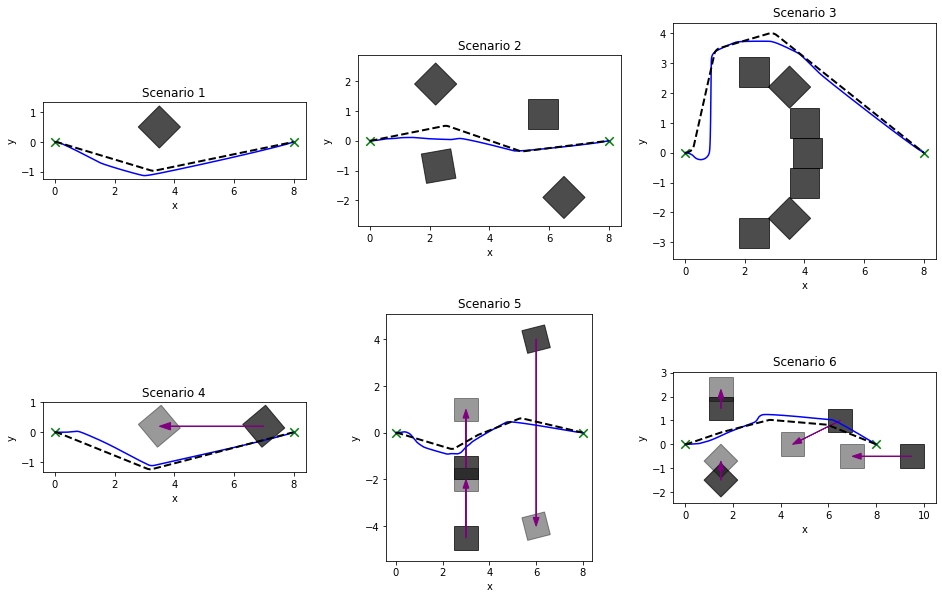

In [217]:
fig = plt.figure(figsize=(16,10))

ax1 = plt.subplot(231)
ax1.set_title("Scenario 1")

ax2 = plt.subplot(232)
ax2.set_title("Scenario 2")

ax3 = plt.subplot(233)
ax3.set_title("Scenario 3")

ax4 = plt.subplot(234)
ax4.set_title("Scenario 4")

ax5 = plt.subplot(235)
ax5.set_title("Scenario 5")

ax6 = plt.subplot(236)
ax6.set_title("Scenario 6")

plot_scenario(scenarios_d[1], df_spb_1.path_all, ax = ax1, size=(8,4))
plot_scenario(scenarios_d[2], df_spb_2.path_all, ax = ax2, size=(8,4))
plot_scenario(scenarios_d[3], df_spb_3.path_all, ax = ax3, size=(8,4))
plot_scenario(scenarios_d[4], df_spb_4.path_all, ax = ax4, size=(8,4))
plot_scenario(scenarios_d[5], df_spb_5.path_all, ax = ax5, size=(8,4))
plot_scenario(scenarios_d[6], df_spb_6.path_all, ax = ax6, size=(8,4))

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()

plt.show()

In [161]:
_df = df_comp.loc[(df_comp['scenario'] == 1)]
_df.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)

,Name,Variable,Value
0,potential_fields,length_n,1.000000
1,ocpBug,length_n,0.000000
2,tangentBug,length_n,0.127725
3,spiderBug,length_n,0.127725
4,potential_fields,av_curvature_n,1.000000
5,ocpBug,av_curvature_n,0.000000
6,tangentBug,av_curvature_n,0.011900
7,spiderBug,av_curvature_n,0.011900
8,potential_fields,tbe_n,1.000000
9,ocpBug,tbe_n,0.000000


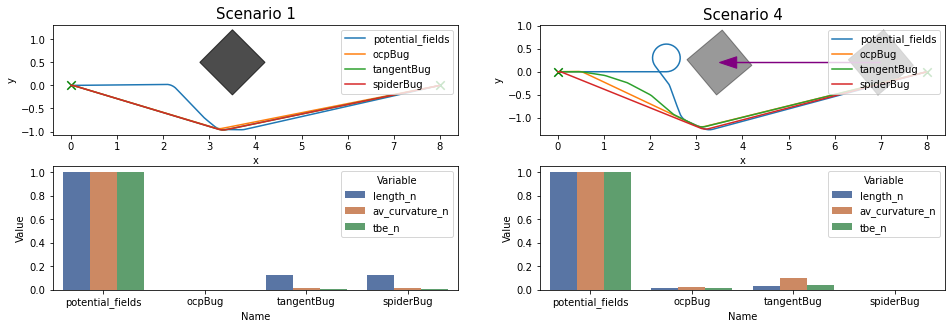

In [177]:
_df_1 = df_comp.loc[(df_comp['scenario'] == 1)]
_df_4 = df_comp.loc[(df_comp['scenario'] == 4)]

fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

# scen 1
plot_paths(scenarios_d[1], _df_1, ax=ax1)
_df_1_t = _df_1.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)
sns.barplot(x="Name", y="Value", hue='Variable', palette="deep", data=_df_1_t, ax=ax3, color=(102/255, 153/255, 255/255, 0.4))

ax1.legend(loc=1)
ax1.set_title("Scenario 1", fontsize=15)

# scen 4
plot_paths(scenarios_d[4], _df_4, ax=ax2)
_df_2_t = _df_4.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)
sns.barplot(x="Name", y="Value", hue='Variable', palette="deep", data=_df_2_t, ax=ax4, color=(102/255, 153/255, 255/255, 0.4))


ax2.legend(loc=1)
ax2.set_title("Scenario 4", fontsize=15)


plt.show()

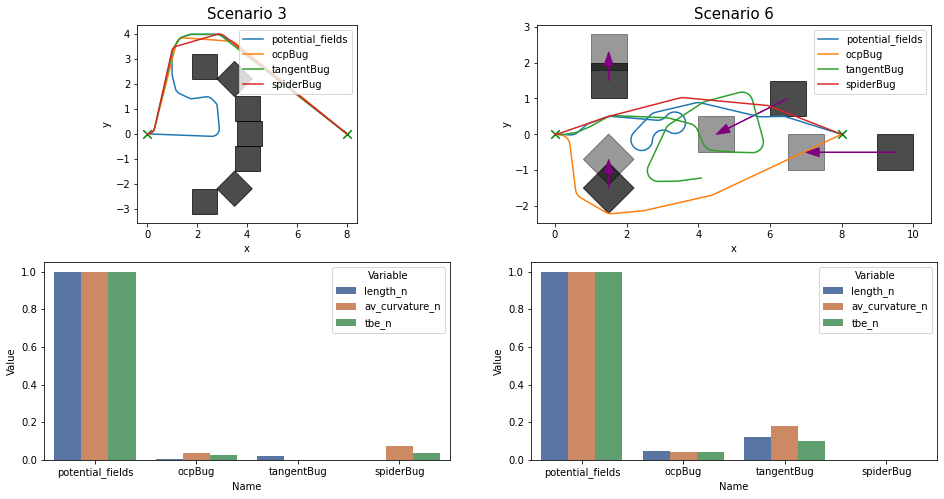

In [174]:
_df_3 = df_comp.loc[(df_comp['scenario'] == 3)]
_df_6 = df_comp.loc[(df_comp['scenario'] == 6)]

fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

# scen 3
plot_paths(scenarios_d[3], _df_3, ax=ax1)
_df_3_t = _df_3.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)
sns.barplot(x="Name", y="Value", hue='Variable', palette="deep", data=_df_3_t, ax=ax3, color=(102/255, 153/255, 255/255, 0.4))

ax1.legend(loc=1)
ax1.set_title("Scenario 3", fontsize=15)

# scen 6
plot_paths(scenarios_d[6], _df_6, ax=ax2)
_df_6_t = _df_4.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)
sns.barplot(x="Name", y="Value", hue='Variable', palette="deep", data=_df_6_t, ax=ax4, color=(102/255, 153/255, 255/255, 0.4))


ax2.legend(loc=1)
ax2.set_title("Scenario 6", fontsize=15)


plt.show()

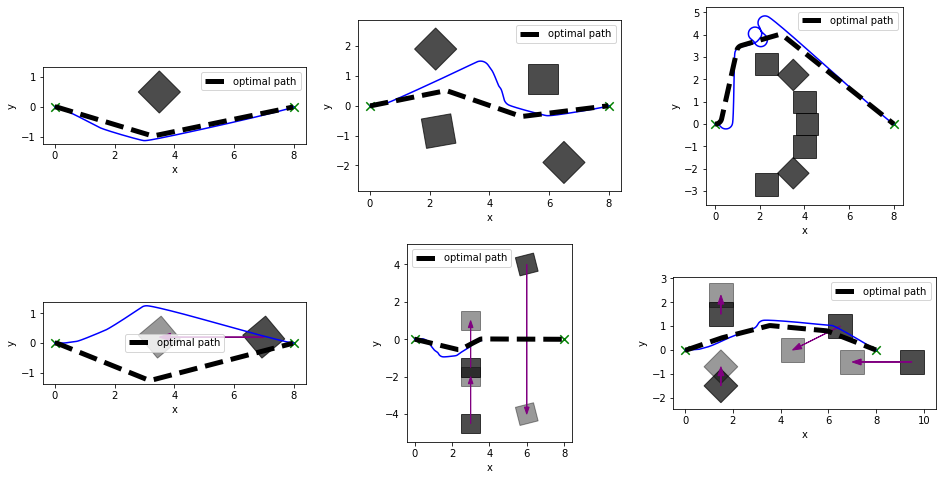

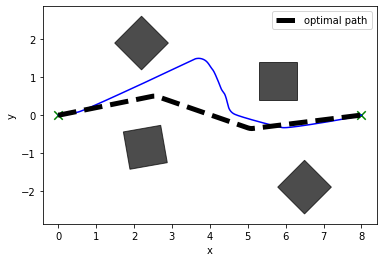

In [182]:
plot_scenario(scenarios_d[2], df_spb_2.path_all)

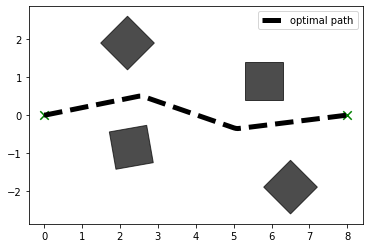

In [115]:
plot_scenario(scenarios_d[2], [])

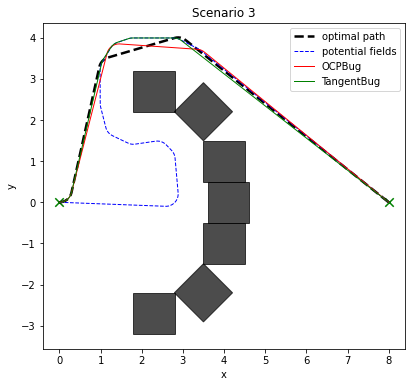

In [76]:
ax = plot_scenario(scenarios_d[3], [], size=(10,6))

ax.plot(potential_fields[:, 0], potential_fields[:, 1], linewidth=1, color="blue", 
    linestyle='dashed', label="potential fields")
ax.plot(ocpbug[:, 0], ocpbug[:, 1], linewidth=1, color="red", 
    label="OCPBug")
ax.plot(tanbug[:, 0], tanbug[:, 1], linewidth=1, color="green", 
    label="TangentBug")


plt.legend()
plt.title("Scenario 3")
plt.show()

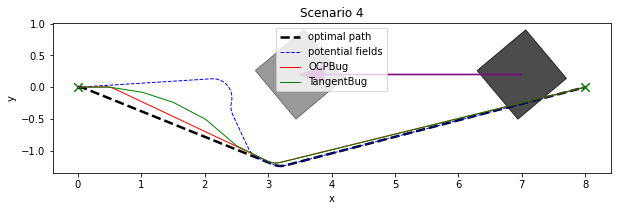

In [98]:
ax = plot_scenario(scenarios_d[4], [], size=(10,6))

ax.plot(potential_fields[:, 0], potential_fields[:, 1], linewidth=1, color="blue", 
    linestyle='dashed', label="potential fields")
ax.plot(ocpbug[:, 0], ocpbug[:, 1], linewidth=1, color="red", 
    label="OCPBug")
ax.plot(tanbug[:, 0], tanbug[:, 1], linewidth=1, color="green", 
    label="TangentBug")


plt.legend()
plt.title("Scenario 4")
plt.show()



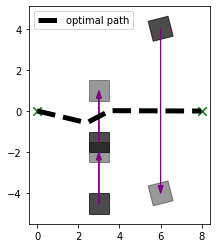

In [118]:
plot_scenario(scenarios_d[5], [])

In [117]:
df_comp

,scenario,name,final_state,path_all,length,av_curvature,tbe
0,1,potential_fields,1.0,"[[0.0, 0.0, 0.0], [0.049997063917763165, 0.000...",11.302923,0.0,0.0
1,1,ocpBug,1.0,"[[0.0, 0.0, 0.0], [0.04976883980802451, -0.004...",11.257481,0.0,0.0
2,1,tangentBug,1.0,"[[0.0, 0.0, 0.0], [0.04976883980802451, -0.004...",11.291688,0.0,0.0
3,3,potential_fields,1.0,"[[0.0, 0.0, 0.0], [0.04996901201317719, -0.001...",16.669845,0.0,0.0
4,3,ocpBug,1.0,"[[0.0, 0.0, 0.0], [0.04976883980802451, 0.0041...",11.300296,0.0,0.0
5,3,tangentBug,1.0,"[[0.0, 0.0, 0.0], [0.04976883980802451, 0.0041...",11.274906,0.0,0.0
6,4,potential_fields,1.0,"[[0.0, 0.0, 0.0], [0.049925574275773314, 0.002...",11.320617,0.0,0.0
7,4,ocpBug,1.0,"[[0.0, 0.0, 0.0], [0.04999588958243579, 0.0006...",11.301704,0.0,0.0
8,4,tangentBug,1.0,"[[0.0, 0.0, 0.0], [0.049999766409289395, 0.000...",11.302658,0.0,0.0
9,6,potential_fields,1.0,"[[0.0, 0.0, 0.0], [0.04996474109260041, -0.001...",15.596860,0.0,0.0


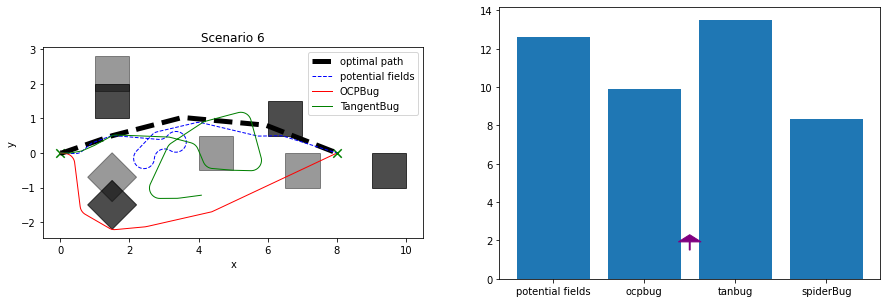

In [114]:
#(1.5, 0.5), (3.508, 1.021), (5.95, 0.8)

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121) # , figsize=(10, 5)
ax2 = plt.subplot(122)

plot_scenario(scenarios_d[6], [], ax=ax1)

ax1.plot(potential_fields[:, 0], potential_fields[:, 1], linewidth=1, color="blue", 
         label="potential fields")
ax1.plot(ocpbug[:, 0], ocpbug[:, 1], linewidth=1, color="red", 
    label="OCPBug")
ax1.plot(tanbug[:, 0], tanbug[:, 1], linewidth=1, color="green", 
    label="TangentBug")

ax1.legend()
ax1.set_title("Scenario 6")

ax2.bar(x=x, height=lengths_6)

plt.show()

In [111]:
eval_length([potential_fields[:, 0], potential_fields[:,1]])

12.613705202023004

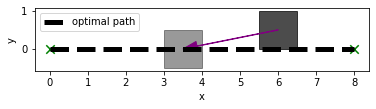

In [13]:
plot_scenario(scenarios_d[7], [])

# 3. Experiment - Hyperparameters
## 3.1 Tolerances
### 3.1.1 Load and Evaluate Data

In [7]:
def circleRadiusFromPoints(A, B, C):
    if A == B or A == C or B == C:
        return math.inf
    yDelta_a = B[1] - A[1]
    xDelta_a = B[0] - A[0]
    yDelta_b = C[1] - B[1]
    xDelta_b = C[0] - B[0]
    center = [0, 0]

    aSlope = yDelta_a/xDelta_a
    bSlope = yDelta_b/xDelta_b
    if aSlope == bSlope:
        return math.inf

    AB_Mid = [(A[0]+B[0])/2, (A[1]+B[1])/2]
    BC_Mid = [(B[0]+C[0])/2, (B[1]+C[1])/2]

    if(yDelta_a == 0):
        center[0] = AB_Mid[0]
        if (xDelta_b == 0):
            center[1] = BC_Mid[1]
        else:
            center[1] = BC_Mid[1] + (BC_Mid[0] - center[0])/bSlope
    elif (yDelta_b == 0):
        center[0] = BC_Mid[0]
        if (xDelta_a == 0):
            center[1] = AB_Mid[1]
        else:
            center[1] = AB_Mid[1] + (AB_Mid[0]-center[0])/aSlope
    elif (xDelta_a == 0):
        center[1] = AB_Mid[1]
        center[0] = bSlope*(BC_Mid[1]-center[1]) + BC_Mid[0]
    elif (xDelta_b == 0):
        center[1] = BC_Mid[1]
        center[0] = aSlope*(AB_Mid[1]-center[1]) + AB_Mid[0]
    else:
        center[0] = (aSlope*bSlope*(AB_Mid[1]-BC_Mid[1]) - aSlope*BC_Mid[0] + bSlope*AB_Mid[0])/(bSlope-aSlope)
        center[1] = AB_Mid[1] - (center[0] - AB_Mid[0])/aSlope

    return math.sqrt((center[0] - A[0]) ** 2. + (center[1] - A[1]) ** 2.)

def eval_smoothness(path, length):
    tbe = 0
    curvatures = []
    for i in np.arange(1, len(path[0])-2):
        cur = (path[0][i],   path[1][i])
        prv = (path[0][i-1], path[1][i-1])
        nxt = (path[0][i+1], path[1][i+1])

        try:
            curvature_cur = 1. / circleRadiusFromPoints(prv, cur, nxt)
        except:
            print("failed with ", prv, cur, nxt)
            raise

        norm_p = (math.sqrt((nxt[0] - cur[0]) ** 2. + (nxt[1] - cur[1]) ** 2.)) / length

        norm_curvature_cur = curvature_cur * length

        curvatures.append(norm_curvature_cur * norm_p)
    
        tbe += math.pow(norm_curvature_cur, 2) * norm_p

    if len(curvatures) == 0:
        mean_curv = 0
    else:
        mean_curv = np.mean(curvatures)
    return mean_curv, tbe
    

In [8]:
def eval_length(path):
    t_len = 0.
    (p_x_0, p_y_0) = path[0][0], path[1][0]
    for (p_x, p_y) in zip(path[0], path[1]):
        t_len += math.sqrt((p_x - p_x_0) ** 2. + (p_y - p_y_0) ** 2.)
        p_x_0, p_y_0 = p_x, p_y
    return t_len

def eval_planning_updates(path_mtg, path_bf):
    """iterates over paths and chooses closest next point"""
    t_len = 0.
    switches = 0
    
    last_mode = "mtg"
    p_x, p_y = 0, 0
    i, j = 0, 0
    while i < len(path_mtg) and j < len(path_bf):
        (x_mtg, y_mtg) = path_mtg[i][0], path_mtg[i][1]
        (x_bf, y_bf) = path_bf[j][0], path_bf[j][1]

        len_mtg = math.sqrt((p_x - x_mtg) ** 2. + (p_y - y_mtg) ** 2.)
        len_bf = math.sqrt((p_x - x_bf) ** 2. + (p_y - y_bf) ** 2.)
        if len_mtg < len_bf:
            # mtg is closer
            if last_mode is "bf":
                switches += 1
            t_len += len_mtg
            p_x, p_y = (x_mtg, y_mtg)
            i += 1
            last_mode = "mtg"
        else:
            # bf is closer
            if last_mode is "mtg":
                switches += 1
            t_len += len_bf
            p_x, p_y = (x_bf, y_bf)
            j +=1
            last_mode = "bf"
    # if rest is mtg
    while i < len(path_mtg):
        (x_mtg, y_mtg) = path_mtg[i][0], path_mtg[i][1]
        len_mtg = math.sqrt((p_x - x_mtg) ** 2. + (p_y - y_mtg) ** 2.)
        # mtg is closer
        if last_mode is "bf":
            switches += 1
        t_len += len_mtg
        p_x, p_y = (x_mtg, y_mtg)
        i += 1
        last_mode = "mtg"
    # if rest is mtg
    while j < len(path_bf):
        (x_bf, y_bf) = path_bf[j][0], path_bf[j][1]
        len_bf = math.sqrt((p_x - x_bf) ** 2. + (p_y - y_bf) ** 2.)
        # bf is closer
        if last_mode is "mtg":
            switches += 1
        t_len += len_bf
        p_x, p_y = (x_bf, y_bf)
        j +=1
        last_mode = "bf"
    return t_len / (len(path_mtg) + len(path_bf)) #, switches

def eval_planning_updates_new(up_path):
    switches = 0
    last_mode = "mtg"
    successful_updates = 0
    last_point = up_path[0][:3]
    t_length = 0.
    for state in up_path:
        point = state[:3]
        new_mode = state[3]
        plan_success = state[4]
        len_t = math.sqrt((last_point[0] - point[0]) ** 2. + (last_point[1] - point[1]) ** 2.)
        t_length += len_t
        if new_mode != last_mode or plan_success == 0:
            switches += 1
            last_mode = new_mode
        if plan_success == 1:
            successful_updates += 1
        last_point = point
    return t_length / len(up_path), switches, successful_updates / len(up_path)

def eval_score(final_state, length_diff, av_curvature, tbe, n_switches, av_update_dist, prop_successful_updates):
    """
    ideal:
        final_state  == 1
        length_diff  == 0
        av_curvature == 0
        tbe          == 0
        n_switches   ~  [1..5]
        av_update_dist          == 0
        prop_successful_updates == 1
    """
    if final_state == 2:
        return 5 + av_update_dist + (1 - prop_successful_updates)
    return abs(final_state - 1) + length_diff + av_curvature + tbe + n_switches + av_update_dist + (1 - prop_successful_updates)

In [9]:
# final state: 0=running, 1=complete, 2=crash

base_dir = "exp_data\\"
df_ = None

def load_data(config_keys, csv_fname, exp_dname, new_p=False, eval_s=True, 
              scenarios=[1, 2, 3, 4, 5, 6], iterations=np.arange(0, 22)):

    if new_p:
        df_ = pd.DataFrame(columns=["scenario", "iteration", *config_keys, "final_state", "path_all", "path_update"])
    else:
        df_ = pd.DataFrame(columns=["scenario", "iteration", *config_keys, "final_state", "path_all", "path_mtg", "path_bf"])
    for s in scenarios:
        for i in iterations:
            if not exists_csv(base_dir, exp_dname, csv_fname, s, i):
                continue
            with open_csv(base_dir, exp_dname, csv_fname, s, i) as csvfile:
                csvReader = csv.reader(csvfile, delimiter=',')
                for j, row in enumerate(csvReader):
                    if j != 0 and len(row) == len(config_keys)+2:
                        # data row
                        with open_path(base_dir, exp_dname, row[-1], s, i) as pyf:
                            if new_p:
                                (r_path, up_path) = pickle.load(pyf)
                                if float(row[-2]) < 2:
                                    r_path[0].append(8.)
                                    r_path[1].append(0.)
                                df_ = df_.append({
                                    "scenario": int(s),
                                    "iteration":  int(i),
                                    **{k:float(z) for k, z in zip(config_keys, row[:len(config_keys)])},
                                    "final_state": float(row[-2]),
                                    "path_all": r_path,
                                    "path_update": up_path,
                                    }, ignore_index=True)
                            else:
                                (r_path, path_mtg, path_bf) = pickle.load(pyf)
                                if float(row[-2]) < 2:
                                    r_path[0].append(8.)
                                    r_path[1].append(0.)
                                df_ = df_.append({
                                    "scenario": int(s),
                                    "iteration":  int(i),
                                    **{k:float(z) for k, z in zip(config_keys, row[:len(config_keys)])},
                                    "final_state": float(row[-2]),
                                    "path_all": r_path,
                                    "path_mtg": path_mtg,
                                    "path_bf": path_bf
                                    }, ignore_index=True)

    # path length
    df_["length"] = df_.apply(lambda row: eval_length(row["path_all"]), axis=1)
    
    # path length - optimal length
    df_["length_diff"] = df_.apply(lambda row: abs(row["length"] - scenarios_d[row["scenario"]]['ref_length']), axis=1)
    
    # performance - mean update distance
    if new_p:
        df_[['av_update_dist', 'n_switches', 'prop_suc_updates']] = \
            df_.apply(lambda row: eval_planning_updates_new(row["path_update"]), axis=1, result_type="expand")
    else:
        df_['av_update_dist'] = df_.apply(lambda row: eval_planning_updates(row["path_mtg"], row["path_bf"]), axis=1)

    # smoothness
    df_[['av_curvature', 'tbe']] = \
        df_.apply(lambda row: eval_smoothness(row["path_all"], row["length"]), axis=1, result_type="expand")

    # normalised version of above
    for scen in scenarios:
        min_max_scaler = preprocessing.MinMaxScaler()
        if new_p:
            df_.loc[(df_['scenario'] == scen), ('length_diff_n', 'av_update_dist_n', 'prop_suc_updates_n', 'av_curvature_n', 'n_switches_n', 'tbe_n')] = \
                min_max_scaler.fit_transform(df_.loc[(df_['scenario'] == scen)][['length_diff', 'av_update_dist', 'prop_suc_updates', 'av_curvature', 'n_switches', 'tbe']])
        else:
            df_.loc[(df_['scenario'] == scen), ('length_diff_n', 'av_update_dist_n', 'av_curvature_n', 'tbe_n')] = \
                min_max_scaler.fit_transform(df_.loc[(df_['scenario'] == scen)][['length_diff', 'av_update_dist', 'av_curvature', 'tbe']])

    
    # score
    if new_p:
        if eval_s:
            df_['score'] =  df_.apply(lambda row: \
                 eval_score(row["final_state"], row["length_diff_n"], row["av_curvature_n"], row["tbe_n"], row["n_switches_n"], row["av_update_dist_n"], row["prop_suc_updates"]), axis=1)
                 #          final_state,         length_diff,         av_curvature,          tbe,            n_switches,         av_update_dist,           prop_successful_updates
        else:
            df_['score'] =  df_.apply(lambda row: \
                 eval_score(row["final_state"], row["length_diff_n"], 0, 0, row["n_switches_n"], row["av_update_dist_n"], row["prop_suc_updates"]), axis=1)
                 #          final_state,         length_diff,         av_curvature,          tbe,            n_switches,         av_update_dist,           prop_successful_updates

    else:
        df_['score'] =  df_.apply(lambda row: \
            (row["length_diff_n"] if row["final_state"] == 1 else 1)  + row["av_curvature_n"] + (row["final_state"] - 1), axis=1) #+ row["av_update_dist_n"]

    df_s_1 = df_.loc[(df_['scenario'] == 1)]
    df_s_2 = df_.loc[(df_['scenario'] == 2)]
    df_s_3 = df_.loc[(df_['scenario'] == 3)]
    df_s_4 = df_.loc[(df_['scenario'] == 4)]
    df_s_5 = df_.loc[(df_['scenario'] == 5)]
    df_s_6 = df_.loc[(df_['scenario'] == 6)]
    df_s_7 = df_.loc[(df_['scenario'] == 6)]
    
    return df_, df_s_1, df_s_2, df_s_3, df_s_4, df_s_5, df_s_6, df_s_7

In [86]:
df_tol, df_tol_1, df_tol_2, df_tol_3, df_tol_4, df_tol_5, df_tol_6, _ = \
    load_data(["H_TOL", "D_TOL"], "TOL", "tolerances", new_p = True)

In [20]:
df_res, df_res_1, df_res_2, df_res_3, df_res_4, df_res_5, df_res_6, _ = \
    load_data(["RES_HORIZONTAL"], "RES", "resolutions", new_p = True)

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by MinMaxScaler.

In [36]:
df_mod, df_mod_1, df_mod_2, df_mod_3, df_mod_4, df_mod_5, df_mod_6, _ = \
    load_data(["ROB_MODEL"], "MOD", "models", new_p = True, eval_s=False)
df_mod.loc[(df_mod['ROB_MODEL'] == 1), 'ROB_MODEL'] = "Det. Holonomic"
df_mod.loc[(df_mod['ROB_MODEL'] == 0), 'ROB_MODEL'] = "Det. Nonholonomic"
df_mod.loc[(df_mod['ROB_MODEL'] == 2), 'ROB_MODEL'] = "Nondet. Holonomic"

In [52]:
min_max_scaler = preprocessing.MinMaxScaler()
df_mod['score_n'] = min_max_scaler.fit_transform(df_mod[['score']])
df_mod['final_state_n'] = min_max_scaler.fit_transform(df_mod[['final_state']])

In [85]:
df_obs, _, _, _, _, _, _, df_obst_7 = \
    load_data(["O_M"], "OBS", "obstacles", new_p = True, scenarios=[7])

In [86]:
min_max_scaler = preprocessing.MinMaxScaler()
df_obs['score_n'] = min_max_scaler.fit_transform(df_obs[['score']])
df_obs['final_state_n'] = min_max_scaler.fit_transform(df_obs[['final_state']])

In [40]:
#mean_update_dist_new(df_tol_d_6.iloc[6].path_update)
df_res.loc[(df_res['scenario'] == 1)][['length_diff', 'av_update_dist', 'av_curvature', 'n_switches', 'tbe']]

,length_diff,av_update_dist,av_curvature,n_switches,tbe
0,4.438984,0.003055,0.011928,217.0,144.993895
1,0.015711,0.004208,0.002304,2.0,231.673038
2,0.052325,0.003993,0.001870,2.0,159.831045
3,0.100437,0.008232,0.002162,4.0,10736.439389
4,0.027342,0.008222,0.001889,0.0,103.688076
5,0.058656,0.008559,0.003261,2.0,1120.692921
6,0.048792,0.004314,0.001828,4.0,183.827827
7,0.057877,0.009008,0.002501,2.0,33029.237732
8,0.008767,0.008185,0.001777,2.0,99.080608
9,0.189913,0.004180,0.002939,10.0,193.099194


In [26]:
df_obs.head()

,scenario,iteration,O_M,final_state,path_all,path_update,length,length_diff,av_update_dist,n_switches,prop_suc_updates,av_curvature,tbe,length_diff_n,av_update_dist_n,prop_suc_updates_n,av_curvature_n,n_switches_n,tbe_n,score
0,7,0,0.0,1.0,"[[0.0, -0.0005463878666927547, -0.000547179468...","[[-0.0005470474352465878, -1.1312722112871373e...",8.239510,0.239510,0.004116,2.0,0.998970,0.001649,22.876290,0.002773,0.028645,0.996232,0.018288,0.002245,0.000003,0.052984
1,7,0,1.0,1.0,"[[0.0, -0.0005465197010438691, -0.000547047435...","[[-0.0005469154420871686, -1.1313294524765245e...",8.572208,0.572208,0.004028,6.0,0.997092,0.002525,40.195749,0.013796,0.026538,0.989365,0.067188,0.006734,0.000007,0.117171
2,7,0,2.0,2.0,"[[0.0, -0.000545992600995068, 0.00077601982321...","[[7.771298329891869, -0.11098870500019285, 0.0...",3.416135,4.583865,0.010337,0.0,1.000000,0.001321,1078.517853,0.146703,0.176395,1.000000,0.000000,0.000000,0.000230,5.176395
3,7,0,3.0,2.0,"[[0.0, -0.0005465197010438691, -0.000547311541...","[[-0.0005471794682183476, -1.1312152636052602e...",1.939271,6.060729,0.003286,68.0,0.884550,0.013041,37313.871172,0.195632,0.008929,0.577850,0.654173,0.076319,0.008024,5.124379
4,7,0,4.0,1.0,"[[0.0, -0.0005441527013445665, -0.000544677605...","[[-0.0005446776057348619, -1.1323512869218253e...",8.732943,0.732943,0.004763,4.0,0.997754,0.004289,624.179597,0.019121,0.044002,0.991788,0.165620,0.004489,0.000133,0.235611


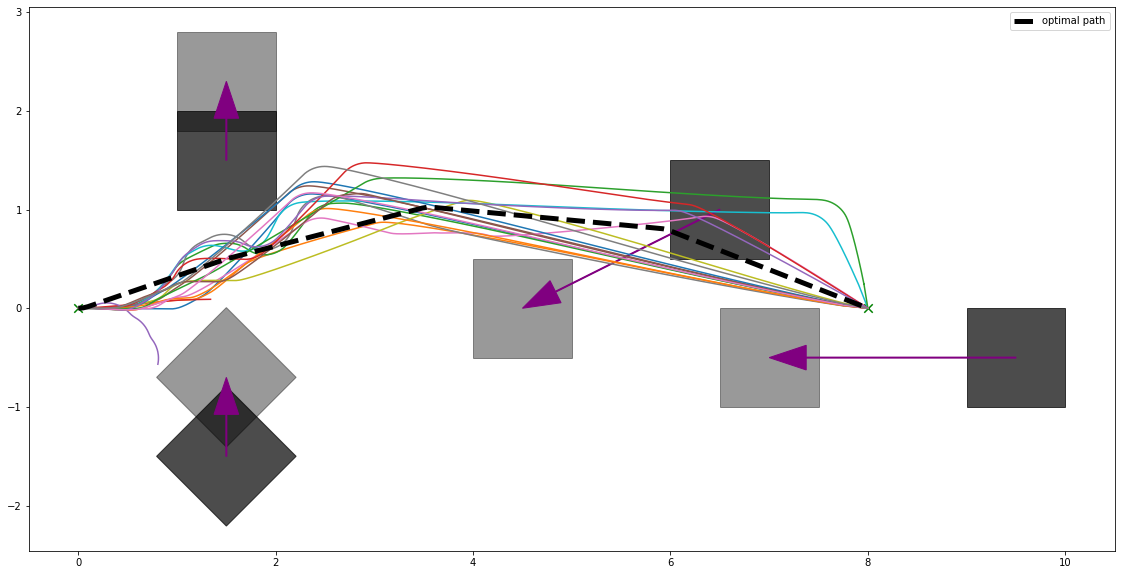

In [221]:
plot_scenario(scenarios_d[6], df_res_6["path_all"], size=(20, 10))

In [261]:
df_res.describe()

,final_state,length,length_diff,av_update_dist,n_switches,prop_suc_updates,av_curvature,tbe,length_diff_n,av_update_dist_n,av_curvature_n,n_switches_n,score
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,1.166667,9.254585,1.213085,0.032416,208.740741,0.979288,0.005172,23112.488132,0.217844,0.587852,0.086802,0.312770,1.392645
std,0.374415,5.040003,5.048378,0.012856,177.070099,0.022621,0.004811,115600.960299,0.136899,0.267926,0.121311,0.267882,0.726209
min,1.000000,1.179747,-6.820253,0.004209,2.000000,0.897776,0.001729,70.491205,0.000000,0.000000,0.000000,0.000000,0.209570
25%,1.000000,8.245548,0.043671,0.021865,41.500000,0.976605,0.002583,196.464442,0.186132,0.367968,0.021532,0.059758,0.761010
50%,1.000000,8.474749,0.417672,0.034464,198.500000,0.981890,0.003847,353.124141,0.196274,0.630548,0.053404,0.297277,1.391738
75%,1.000000,9.330490,1.330490,0.042977,320.500000,0.993835,0.006025,1307.320068,0.221027,0.807954,0.108318,0.481846,1.727535
max,2.000000,38.056348,30.056348,0.052192,663.000000,0.998989,0.041385,962819.870217,1.000000,1.000000,1.000000,1.000000,4.257304


count    300.000000
mean       0.996105
std        0.371319
min        0.263265
25%        0.760830
50%        0.989691
75%        1.122207
max        3.082123
Name: score, dtype: float64

In [206]:
p_t_0 = df.loc[(df['scenario'] == 1) & (df['iteration'] == 1) & (df['H_TOL'] == '0.0') & (df['D_TOL'] == '0.0')].iloc[0]['path_mtg']
p_t_1 = df.loc[(df['scenario'] == 1) & (df['iteration'] == 1) & (df['H_TOL'] == '0.0') & (df['D_TOL'] == '0.0')].iloc[0]['path_bf']
mean_update_dist(p_t_0, p_t_1)

(0.0046700142687125384, 112)

### 1.1.4 Explore Data
    - heatmap of path lengths, smoothness
    - heatmap of crashes
    - all paths overlayed for a scenario

In [215]:

#df_s_1.loc[(df_s_1['iteration'] == 1)]

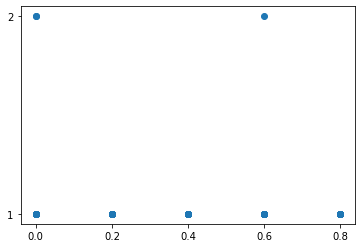

In [307]:
plt.figure()
plt.scatter(df_s_1.D_TOL, df_s_1.final_state)
plt.show()

In [89]:
def plt_heatmap(df, scenario, d_var='length'):
    df_s = df.loc[(df['scenario'] == scenario)]
    df_p = df_s.loc[(df_s['iteration'] == 0)].pivot('H_TOL', 'D_TOL', d_var)
    df_p = (df_p + df_s.loc[(df_s['iteration'] == 1)].pivot('H_TOL', 'D_TOL', d_var))/2
    sns.heatmap(df_p, annot=True,  linewidths=.2)
    
def plt_heatmap_mult(df, scenarios, d_var='length', ax=None):
    df_s = df.loc[(df['scenario'] == scenarios[0])]
    df_p = df_s.loc[(df_s['iteration'] == 0)].pivot('H_TOL', 'D_TOL', d_var).fillna(1) + df_s.loc[(df_s['iteration'] == 1)].pivot('H_TOL', 'D_TOL', d_var).fillna(1)
    for scen in scenarios[1:]:
        df_s = df.loc[(df['scenario'] == scen)]
        df_p = df_p + df_s.loc[(df_s['iteration'] == 0)].pivot('H_TOL', 'D_TOL', d_var).fillna(1) + df_s.loc[(df_s['iteration'] == 1)].pivot('H_TOL', 'D_TOL', d_var).fillna(1)
    df_p = df_p/(2*len(scenarios))
    ax = sns.heatmap(df_p, annot=True,  linewidths=.2, ax=ax)
    return ax

In [91]:
df_res.loc[(df_res['RES_HORIZONTAL'] > 60)].describe()

,RES_HORIZONTAL,final_state,length,length_diff,av_update_dist,n_switches,prop_suc_updates,av_curvature,tbe,length_diff_n,av_update_dist_n,prop_suc_updates_n,av_curvature_n,n_switches_n,tbe_n,score
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,1.440000e+02,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,600.000000,1.111111,10.080714,2.006320,0.007953,27.541667,0.987712,0.004803,2.112547e+05,0.138694,0.385790,0.910395,0.181274,0.082109,0.066519,1.349097
std,275.914246,0.315367,6.034229,5.659502,0.007113,190.837714,0.063279,0.003219,1.146714e+06,0.277188,0.347190,0.196247,0.186973,0.195396,0.211513,1.555882
min,180.000000,1.000000,1.580820,0.001799,0.003034,0.000000,0.257012,0.001716,1.963764e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025092
25%,390.000000,1.000000,8.278365,0.043520,0.005356,2.000000,0.991924,0.002780,2.128566e+02,0.002806,0.069937,0.935933,0.051889,0.005048,0.000073,0.337529
50%,600.000000,1.000000,8.574822,0.128349,0.007975,6.000000,0.996839,0.003872,1.101997e+03,0.011771,0.263789,0.971528,0.133274,0.019704,0.000513,0.863886
75%,810.000000,1.000000,10.351184,1.031162,0.009156,14.000000,0.998896,0.005873,8.449667e+03,0.094495,0.752816,0.994154,0.268035,0.052841,0.005479,1.487014
max,1020.000000,2.000000,38.567468,30.232168,0.086609,2278.000000,1.000000,0.028210,1.161393e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.030660


## Resolution Plots

In [89]:
min_max_scaler = preprocessing.MinMaxScaler()
df_res['final_state_n'] = min_max_scaler.fit_transform(df_res[['final_state']])

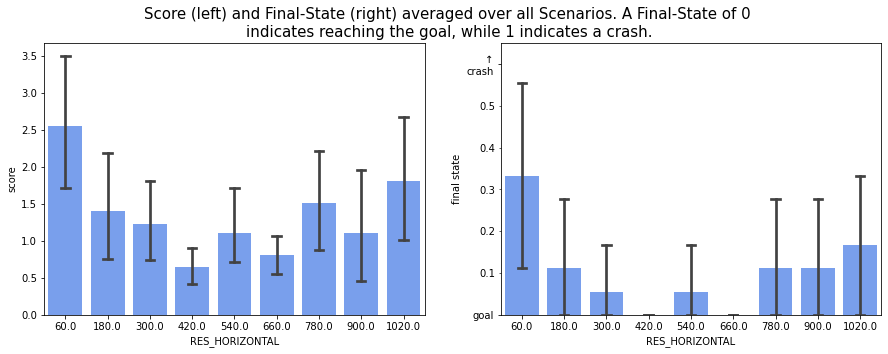

In [119]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121) # , figsize=(10, 5)
ax2 = plt.subplot(122)

ax1 = sns.barplot(x="RES_HORIZONTAL", y="score", data=df_res, capsize=.2, ax=ax1, color=(102/255, 153/255, 255/255, 0.4))

ax2 = sns.barplot(x="RES_HORIZONTAL", y="final_state_n", data=df_res, capsize=.2, ax=ax2, color=(102/255, 153/255, 255/255, 0.4))
ax2.set_yticks([0., .6])
ax2.set_yticklabels(["goal", "↑\ncrash"])
ax2.set_yticks(np.around(np.arange(0.1, 0.6, 0.1), decimals=1), minor=True)
ax2.set_yticklabels(np.around(np.arange(0.1, 0.6, 0.1), decimals=1), minor=True)
ax2.set_ylabel("final state")
ax2.set_ylim(0, 0.65)
# (0 indicates reaching the goal, while 1 \nindicates a crash)

fig.suptitle("Score (left) and Final-State (right) averaged over all Scenarios. A Final-State of 0 \nindicates reaching the goal, while 1 indicates a crash.", fontsize=15)
plt.show()


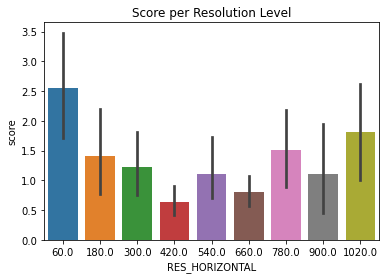

In [128]:
ax = sns.barplot(x="RES_HORIZONTAL", y="score", data=df_res)
ax.set_title("Score per Resolution Level")
plt.show()

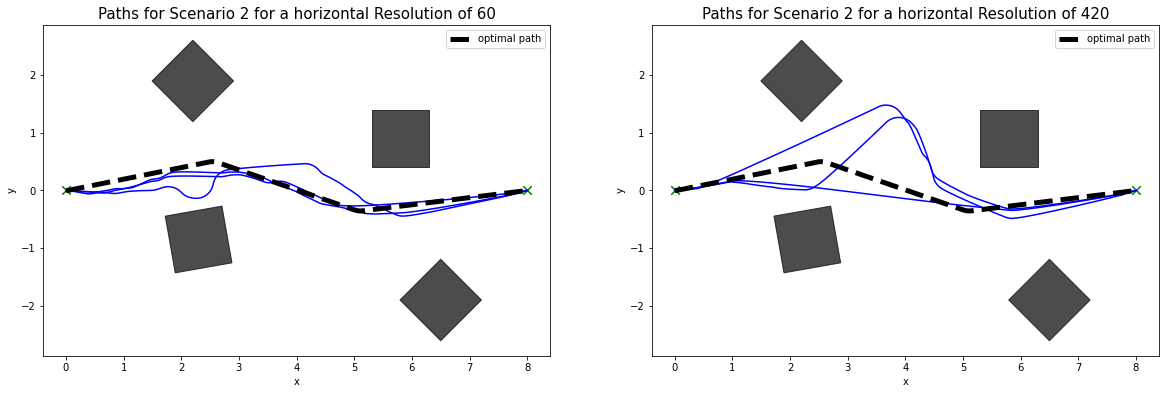

In [106]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


plot_scenario(scenarios_d[2], df_res_2.loc[(df_res['RES_HORIZONTAL'] == 60), 'path_all'], ax=ax1)
ax1.set_title("Paths for Scenario 2 for a horizontal Resolution of 60", fontsize=15)
#ax1.set_ylim(-2, 2)

plot_scenario(scenarios_d[2], df_res_2.loc[(df_res['RES_HORIZONTAL'] == 420), 'path_all'], ax=ax2)
ax2.set_title("Paths for Scenario 2 for a horizontal Resolution of 420", fontsize=15)
#ax2.set_ylim(-2, 2)

plt.show()

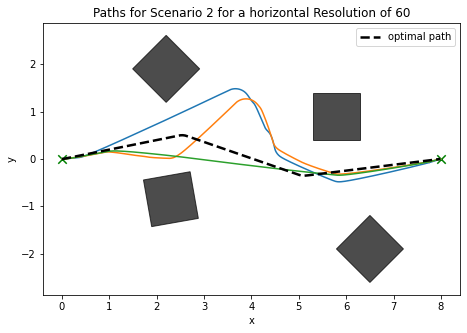

In [143]:
plot_scenario(scenarios_d[2], df_res_2.loc[(df_res['RES_HORIZONTAL'] == 420), 'path_all'], size=(10, 5))
plt.title("Paths for Scenario 2 for a horizontal Resolution of 420")
plt.show()

In [119]:
df_res.iloc[df_res['length'].argmax()]

scenario                                                              5
iteration                                                             2
RES_HORIZONTAL                                                      300
final_state                                                           2
path_all              [[0.0, -0.00013321273641584926, 0.001190746276...
path_update           [[7.805996874901763, -0.154272855257832, 0.0, ...
length                                                          38.2451
length_diff                                                     30.0104
av_update_dist                                                0.0117819
n_switches                                                           26
prop_suc_updates                                               0.993345
av_curvature                                                 0.00603787
tbe                                                             8450.32
length_diff_n                                                   

 ## Tolerances Experiment

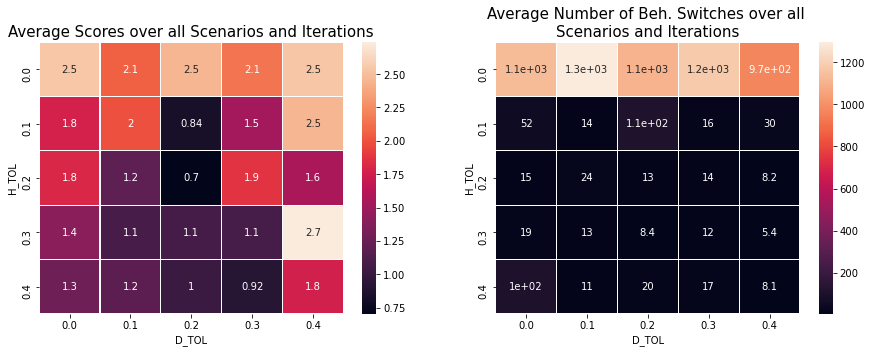

In [88]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121) # , figsize=(10, 5)
ax2 = plt.subplot(122)

ax1 = plt_heatmap_mult(df_tol, [1,2,3,4,5,6], "score", ax=ax1)
ax1.set_title('Average Scores over all Scenarios and Iterations', fontsize = 15) 

ax2 = plt_heatmap_mult(df_tol, [1,2,3,4,5,6], "n_switches", ax=ax2)
ax2.set_title("Average Number of Beh. Switches over all \nScenarios and Iterations", fontsize = 15)

plt.show()

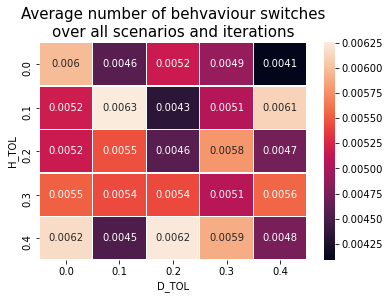

In [90]:
plt_heatmap_mult(df_tol, [1,2,3,4,5,6], "av_curvature")
plt.title('Average number of behvaviour switches\nover all scenarios and iterations', fontsize = 15) 
plt.show()

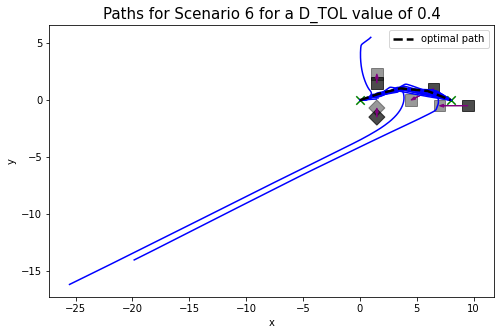

In [112]:
plot_scenario(scenarios_d[6], df_tol_6.loc[(df_tol_6['D_TOL'] == 0.4), 'path_all'], size=(10, 5))
plt.title("Paths for Scenario 6 for a D_TOL value of 0.4", fontsize=15)
plt.show()

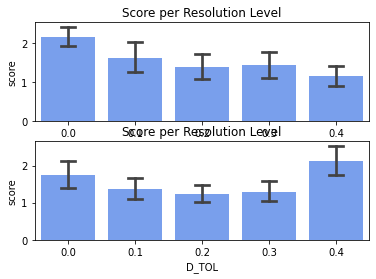

In [50]:
ax1 = plt.subplot(211) # , figsize=(10, 5)
ax2 = plt.subplot(212)

ax1 = sns.barplot(x="H_TOL", y="score", data=df_tol, color=(102/255, 153/255, 255/255, 0.4), capsize=.2, ax=ax1)
ax1.set_title("Score per Resolution Level")

ax2 = sns.barplot(x="D_TOL", y="score", data=df_tol, color=(102/255, 153/255, 255/255, 0.4), capsize=.2, ax=ax2)
ax2.set_title("Score per Resolution Level")

plt.show()

In [77]:
df_tol.head()

,scenario,iteration,H_TOL,D_TOL,final_state,path_all,path_update,length,length_diff,av_update_dist,...,prop_suc_updates,av_curvature,tbe,length_diff_n,av_update_dist_n,prop_suc_updates_n,av_curvature_n,n_switches_n,tbe_n,score
0,1,0,0.0,0.0,1.0,"[[0.0, -0.00013311348064829872, -0.00013351052...","[[-0.00013341125959357908, -2.993642239849689e...",8.190138,0.050115,0.003795,...,0.395315,0.002219,166.820821,0.202312,0.011250,0.031507,0.179887,0.948987,4.975354e-06,1.947126
1,1,0,0.0,0.1,1.0,"[[0.0, -0.00013311348064829872, 0.001619404474...","[[7.759016664066755, -0.06000325808864854, 0.0...",8.229412,0.010841,0.006996,...,0.436639,0.003075,53686.057109,0.039465,0.690100,0.097692,0.502270,0.950488,3.499101e-03,2.749183
2,1,0,0.0,0.2,1.0,"[[0.0, -0.00013311348064829872, -0.00013360980...","[[7.757934679167829, -0.06878957248010363, 0.0...",8.193323,0.046931,0.006692,...,0.628730,0.002005,105.334602,0.189109,0.625622,0.405355,0.099539,0.653413,9.610853e-07,1.938955
3,1,0,0.0,0.3,1.0,"[[0.0, -0.00013311348064829872, -0.00013360980...","[[7.756304770000909, -0.06354822784575456, 0.0...",8.353511,0.113258,0.006634,...,0.613969,0.004397,18248.286983,0.464128,0.613210,0.381713,1.000000,0.692423,1.185465e-03,3.156978
4,1,0,0.0,0.4,1.0,"[[0.0, -0.00013311348064829872, 0.001190363886...","[[7.790404937510005, 0.13686506611956423, 0.0,...",8.196253,0.044000,0.006569,...,0.642589,0.002452,21443.360963,0.176956,0.599591,0.427552,0.267716,0.642161,1.394063e-03,2.045230


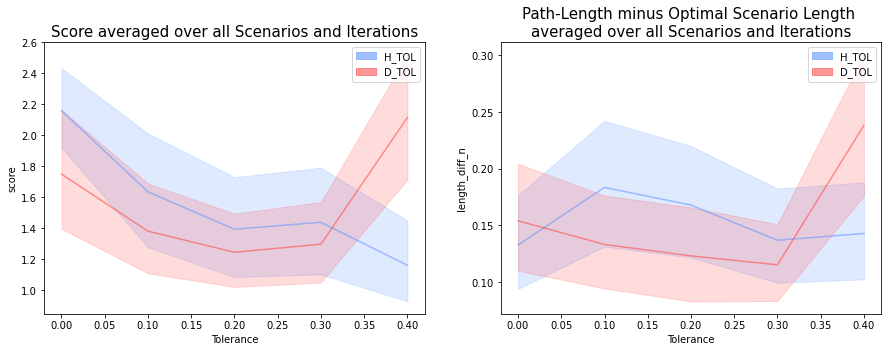

In [103]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121) # , figsize=(10, 5)
ax2 = plt.subplot(122)

# seaborn plots
ax1 = sns.lineplot(x="H_TOL", y="score", data=df_tol, color=(102/255, 153/255, 255/255, 0.6), ax=ax1, markers=True)
ax1 = sns.lineplot(x="D_TOL", y="score", data=df_tol, color=(255/255, 80/255, 80/255, 0.6), ax=ax1, markers=True)

# matplotlib elements
ax1.set_xlabel("Tolerance")
ax1.set_title("Score averaged over all Scenarios and Iterations", fontsize=15)
patch_0 = mpatches.Patch(color=(102/255, 153/255, 255/255, 0.6), label='H_TOL')
patch_1 = mpatches.Patch(color=(255/255, 80/255, 80/255, 0.6), label='D_TOL')
ax1.legend(handles=[patch_0, patch_1])

# seaborn plots
ax2 = sns.lineplot(x="H_TOL", y="length_diff_n", data=df_tol, color=(102/255, 153/255, 255/255, 0.6), ax=ax2, markers=True)
ax2 = sns.lineplot(x="D_TOL", y="length_diff_n", data=df_tol, color=(255/255, 80/255, 80/255, 0.6), ax=ax2, markers=True)

ax2.set_xlabel("Tolerance")
ax2.set_title("Path-Length minus Optimal Scenario Length \naveraged over all Scenarios and Iterations", fontsize=15)
ax2.legend(handles=[patch_0, patch_1])


plt.show()

## Models experiment

In [141]:
df_mod.iloc[df_mod['length'].argmax()]

scenario                                                              5
iteration                                                             0
ROB_MODEL                                                             2
final_state                                                           2
path_all              [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
path_update           [[0.0, 0.0, 0.0, mtg, 1], [0.0, 0.0, 0.0, bf, ...
length                                                          35.5644
length_diff                                                     27.3297
av_update_dist                                                0.0095194
n_switches                                                           81
prop_suc_updates                                               0.978284
av_curvature                                                 0.00976182
tbe                                                             82569.7
length_diff_n                                                   

In [40]:
df_mod

,scenario,iteration,ROB_MODEL,final_state,path_all,path_update,length,length_diff,av_update_dist,n_switches,...,av_curvature,tbe,length_diff_n,av_update_dist_n,prop_suc_updates_n,av_curvature_n,n_switches_n,tbe_n,score,final_state_n
0,1,0,Det. Nonholonomic,1.0,"[[0.0, -0.0005463878666927547, -0.000547047435...","[[-0.0005469154420871686, -1.1313294524765245e...",8.300005,0.059751,0.004220,6.0,...,0.002389,132537.904400,0.005226,0.046049,0.967638,0.004001,0.024793,0.057280,0.079215,0.0
1,1,0,Det. Holonomic,1.0,"[[0.0, 0.001827666157165104, 0.004551075263881...","[[7.758336974593208, -0.07098264740967004, 0.0...",8.209029,0.031224,0.007888,0.0,...,0.000640,446.660203,0.002431,0.859866,1.000000,0.000000,0.000000,0.000180,0.862297,0.0
2,1,0,Nondet. Holonomic,2.0,"[[0.0, 0.0017603817432267463, 0.00349584506094...","[[7.755655704001638, -0.03931735019512617, 0.0...",7.747810,0.492444,0.008470,50.0,...,0.383257,509895.432801,0.047620,0.989065,0.718200,0.875605,0.206612,0.220402,6.016462,1.0
3,1,1,Det. Nonholonomic,1.0,"[[0.0, -0.0005465197010438691, -0.000547179468...","[[-0.0005470474352465878, -1.1312722112871373e...",8.355066,0.114812,0.004477,2.0,...,0.002096,253.393859,0.010621,0.103155,0.988635,0.003331,0.008264,0.000096,0.123145,0.0
4,1,1,Det. Holonomic,1.0,"[[0.0, 0.0018276561224840043, 0.00410318126073...","[[7.761406622087505, -0.07552526875192621, 0.0...",8.247064,0.006810,0.007794,0.0,...,0.000699,518.227855,0.000039,0.839028,1.000000,0.000135,0.000000,0.000211,0.839067,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,6,4,Det. Holonomic,1.0,"[[0.0, 0.0022755724254893426, 0.00410326652813...","[[7.755338077908519, 0.05652660567046563, 0.0,...",8.380971,0.039777,0.009975,4.0,...,0.002381,1300.100148,0.005597,0.180596,1.000000,0.002470,0.000000,0.001813,0.188704,0.0
104,6,4,Nondet. Holonomic,2.0,"[[0.0, 0.0019979668992104955, 0.00444778941500...","[[7.763698035826726, 0.06321515827967744, 0.0,...",7.734761,0.606433,0.010853,78.0,...,0.402107,569248.160312,0.089898,0.213754,0.702912,0.878905,1.000000,0.833815,5.268995,1.0
105,6,5,Det. Nonholonomic,1.0,"[[0.0, -0.0005465197010438691, -0.000547179468...","[[-0.0005470474352465878, -1.1312722112871373e...",8.682564,0.341371,0.006426,8.0,...,0.006571,121.035925,0.050465,0.046412,0.979793,0.011657,0.054054,0.000086,0.157028,0.0
106,6,5,Det. Holonomic,1.0,"[[0.0, 0.004030909460799916, 0.006306469095909...","[[7.766456149597977, 0.062309931868809745, 0.0...",8.339037,0.002156,0.012598,10.0,...,0.003718,1931.269877,0.000000,0.279719,0.969361,0.005403,0.081081,0.002738,0.368749,0.0


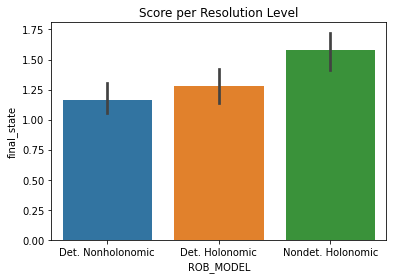

In [47]:
ax = sns.barplot(x="ROB_MODEL", y="final_state", data=df_mod)
ax.set_title("Score per Resolution Level")
plt.show()

In [37]:
min_max_scaler = preprocessing.MinMaxScaler()
df_mod['final_state_n'] = min_max_scaler.fit_transform(df_mod[['final_state']])

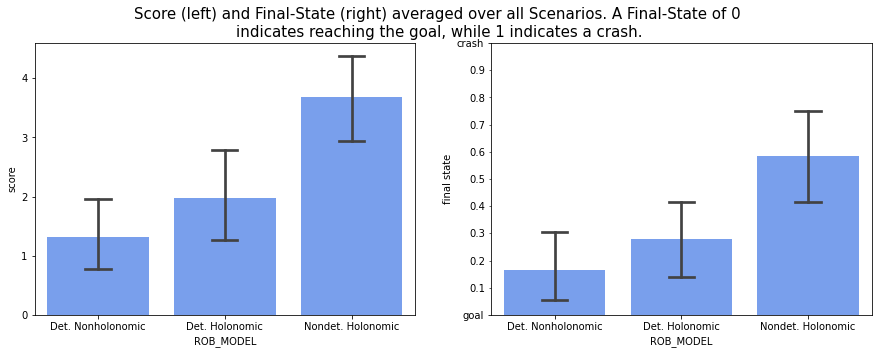

In [38]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121) # , figsize=(10, 5)
ax2 = plt.subplot(122)

ax1 = sns.barplot(x="ROB_MODEL", y="score", data=df_mod, capsize=.2, ax=ax1, color=(102/255, 153/255, 255/255, 0.4))

ax2 = sns.barplot(x="ROB_MODEL", y="final_state_n", data=df_mod, capsize=.2, ax=ax2, color=(102/255, 153/255, 255/255, 0.4))
ax2.set_yticks([0., 1])
ax2.set_yticklabels(["goal", "crash"])
ax2.set_yticks(np.around(np.arange(0.1, 1, 0.1), decimals=1), minor=True)
ax2.set_yticklabels(np.around(np.arange(0.1, 1, 0.1), decimals=1), minor=True)
ax2.set_ylabel("final state")
ax2.set_ylim(0, 1)
# (0 indicates reaching the goal, while 1 \nindicates a crash)

fig.suptitle("Score (left) and Final-State (right) averaged over all Scenarios. A Final-State of 0 \nindicates reaching the goal, while 1 indicates a crash.", fontsize=15)
plt.show()


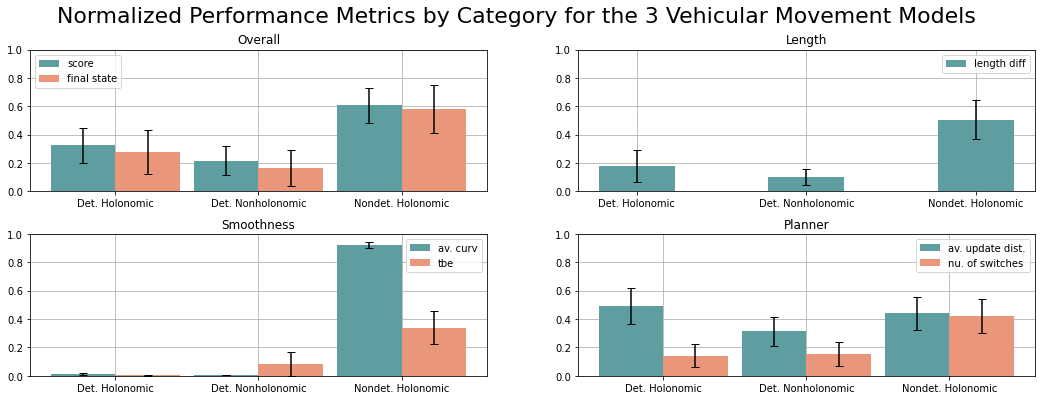

In [77]:
barWidth = 0.45

fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.grid(zorder=0)
ax2.grid(zorder=0)
ax3.grid(zorder=0)
ax4.grid(zorder=0)

models = ["Det. Holonomic", "Det. Nonholonomic", "Nondet. Holonomic"]
models_i = np.arange(0, 3)
df_t = df_mod.groupby(['ROB_MODEL']).mean()

y_err_1 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'score_n']) for i in models]
y_err_2_1 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'final_state_n']) for i in models]
ax1.bar(models_i-barWidth/2, df_t.score_n, width=barWidth, label="score", yerr=y_err_1, capsize=4, zorder=3, color="CadetBlue")
ax1.bar(models_i+barWidth/2, df_t.final_state_n, width=barWidth, label="final state", yerr=y_err_2_1, capsize=4, zorder=3, color="DarkSalmon")

y_err_2 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'length_diff_n']) for i in models]
ax2.bar(models_i, df_t.length_diff_n, width=barWidth, label="length diff", yerr=y_err_2, capsize=4, zorder=3, color="CadetBlue")

y_err_3 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'av_curvature_n']) for i in models]
y_err_3_1 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'tbe_n']) for i in models]
ax3.bar(models_i-barWidth/2, df_t.av_curvature_n, width=barWidth, label="av. curv", yerr=y_err_3, capsize=4, zorder=3, color="CadetBlue")
ax3.bar(models_i+barWidth/2, df_t.tbe_n, width=barWidth, label="tbe", yerr=y_err_3_1, capsize=4, zorder=3, color="DarkSalmon")

y_err_4 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'av_update_dist_n']) for i in models]
y_err_4_1 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'n_switches_n']) for i in models]
ax4.bar(models_i-barWidth/2, df_t.av_update_dist_n, width=barWidth, label="av. update dist.", yerr=y_err_4, capsize=4, zorder=3, color="CadetBlue")
ax4.bar(models_i+barWidth/2, df_t.n_switches_n, width=barWidth, label="nu. of switches", yerr=y_err_4_1, capsize=4, zorder=3, color="DarkSalmon")

ax1.set_title("Overall")
ax3.set_title("Smoothness")
ax4.set_title("Planner")
ax2.set_title("Length")

ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,1)
ax4.set_ylim(0,1)

ax1.set_xticks(models_i)
ax1.set_xticklabels(models)
ax2.set_xticks(models_i)
ax2.set_xticklabels(models)
ax3.set_xticks(models_i)
ax3.set_xticklabels(models)
ax4.set_xticks(models_i)
ax4.set_xticklabels(models)


ax1.legend(loc=0)
ax2.legend(loc=1)
ax3.legend(loc=0)
ax4.legend(loc=0)

fig.suptitle("Normalized Performance Metrics by Category for the 3 Vehicular Movement Models", fontsize=22, )
fig.subplots_adjust(hspace = 0.3) 
plt.show()

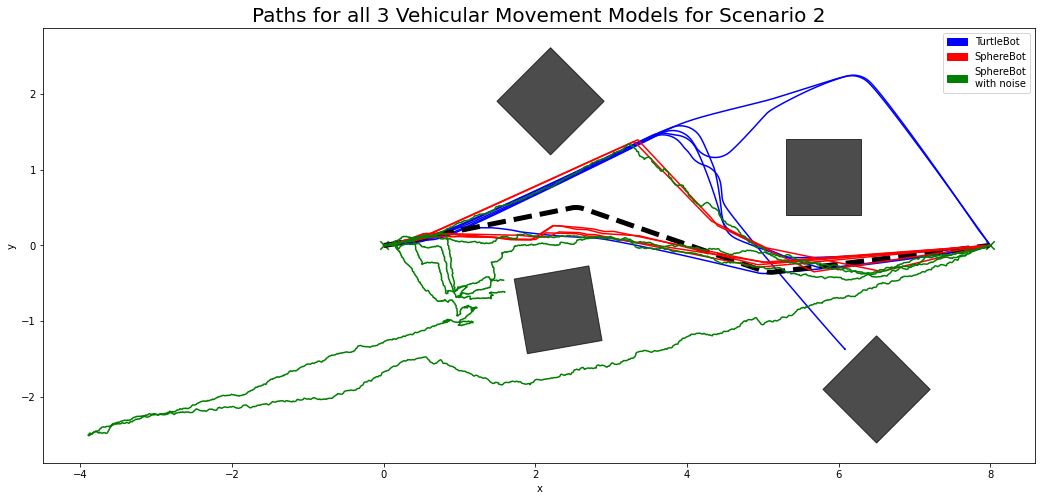

In [84]:
def my_plot(scen, _df):
    fig = plt.figure(figsize=(20,8))
    ax1 = plt.subplot(111)

    plot_scenario(scenarios_d[scen], _df.loc[(_df['ROB_MODEL'] == 0), 'path_all'], ax=ax1)
    #ax1.set_ylim(-2, 2)
    plot_scenario(scenarios_d[scen], _df.loc[(_df['ROB_MODEL'] == 1), 'path_all'], ax=ax1, col="red", only_paths=True)
    plot_scenario(scenarios_d[scen], _df.loc[(_df['ROB_MODEL'] == 2), 'path_all'], ax=ax1, col="green", only_paths=True)

    patch_0 = mpatches.Patch(color="blue", label='TurtleBot')
    patch_1 = mpatches.Patch(color="red", label='SphereBot')
    patch_2 = mpatches.Patch(color="green", label='SphereBot\nwith noise')

    plt.legend(handles=[patch_0, patch_1, patch_2])
    plt.title("Paths for all 3 Vehicular Movement Models for Scenario " + str(scen), fontsize=20)

    plt.show()
my_plot(2, df_mod_2)

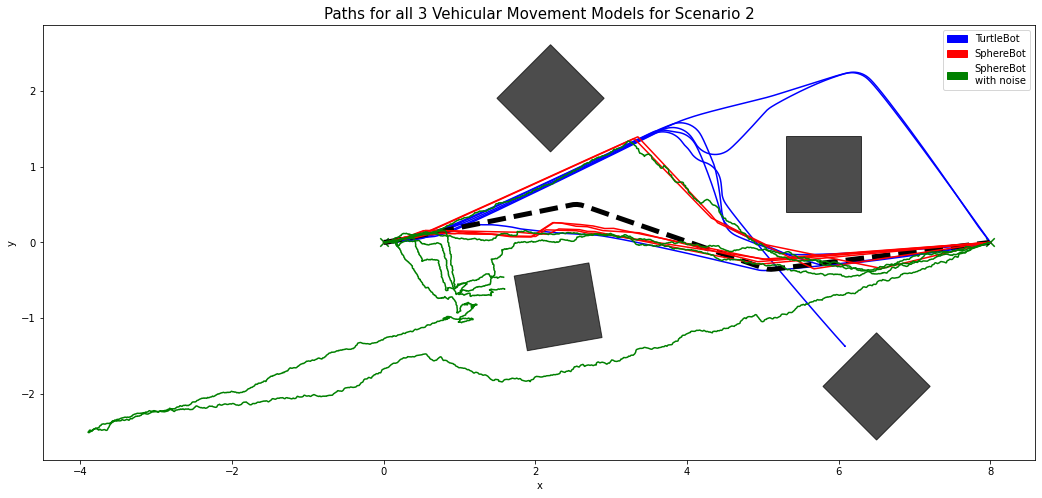

In [83]:
fig = plt.figure(figsize=(20,8))
ax1 = plt.subplot(111)

plot_scenario(scenarios_d[2], df_mod_2.loc[(df_mod_2['ROB_MODEL'] == 0), 'path_all'], ax=ax1)
#ax1.set_ylim(-2, 2)
plot_scenario(scenarios_d[2], df_mod_2.loc[(df_mod_2['ROB_MODEL'] == 1), 'path_all'], ax=ax1, col="red", only_paths=True)
plot_scenario(scenarios_d[2], df_mod_2.loc[(df_mod_2['ROB_MODEL'] == 2), 'path_all'], ax=ax1, col="green", only_paths=True)

patch_0 = mpatches.Patch(color="blue", label='TurtleBot')
patch_1 = mpatches.Patch(color="red", label='SphereBot')
patch_2 = mpatches.Patch(color="green", label='SphereBot\nwith noise')

plt.legend(handles=[patch_0, patch_1, patch_2])
plt.title("Paths for all 3 Vehicular Movement Models for Scenario 2", fontsize=15)

plt.show()

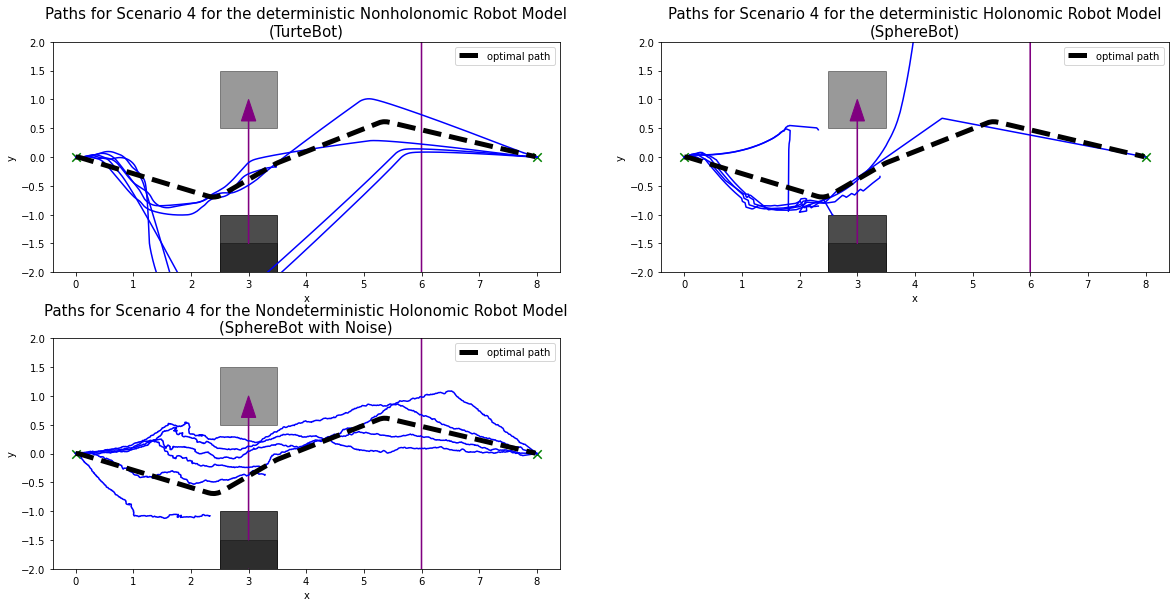

In [17]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)


plot_scenario(scenarios_d[5], df_mod_5.loc[(df_mod_5['ROB_MODEL'] == 0), 'path_all'], ax=ax1)
ax1.set_title("Paths for Scenario 4 for the deterministic Nonholonomic Robot Model\n(TurteBot)", fontsize=15)
ax1.set_ylim(-2, 2)

plot_scenario(scenarios_d[5], df_mod_5.loc[(df_mod_5['ROB_MODEL'] == 1), 'path_all'], ax=ax2)
ax2.set_title("Paths for Scenario 4 for the deterministic Holonomic Robot Model\n(SphereBot)", fontsize=15)
ax2.set_ylim(-2, 2)

plot_scenario(scenarios_d[5], df_mod_5.loc[(df_mod_5['ROB_MODEL'] == 2), 'path_all'], ax=ax3)
ax3.set_title("Paths for Scenario 4 for the Nondeterministic Holonomic Robot Model\n(SphereBot with Noise)", fontsize=15)
ax3.set_ylim(-2, 2)

plt.show()

## Obstacle Experiment

In [263]:
df_obs.id

AttributeError: 'DataFrame' object has no attribute 'id'

In [286]:
min_max_scaler = preprocessing.MinMaxScaler()
df_obs['score_n'] = min_max_scaler.fit_transform(df_obs[['score']])
df_obs['final_state_n'] = min_max_scaler.fit_transform(df_obs[['final_state']])

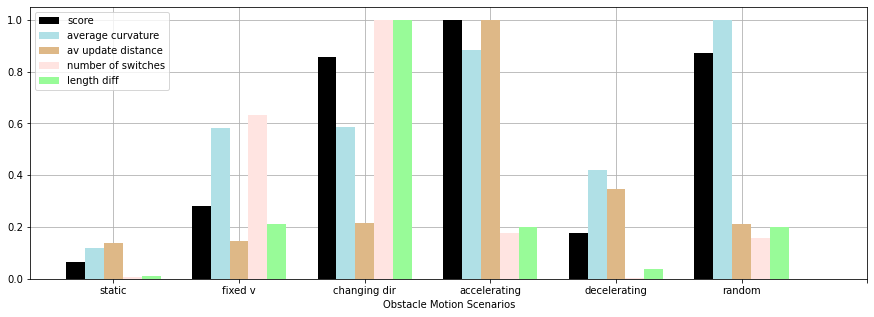

In [211]:
barWidth = 0.15

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(111)
ax1.grid(zorder=0)

ax1.bar(df_obs.O_M, df_obs.score_n, width=barWidth, label="score", zorder=3, color="black")
ax1.bar(df_obs.O_M+1*barWidth, df_obs.av_curvature_n, width=barWidth, label="average curvature", zorder=3, color="PowderBlue")
ax1.bar(df_obs.O_M+2*barWidth, df_obs.av_update_dist_n, width=barWidth, label="av update distance", zorder=3, color="BurlyWood")
ax1.bar(df_obs.O_M+3*barWidth, df_obs.n_switches_n, width=barWidth, label="number of switches", zorder=3, color="MistyRose")
ax1.bar(df_obs.O_M+4*barWidth, df_obs.length_diff_n, width=barWidth, label="length diff", zorder=3, color="PaleGreen")
# 

ax1.set_xlabel('Obstacle Motion Scenarios')
ax1.set_xticks([r + 2*barWidth for r in range(7)])
ax1.set_xticklabels(['static', 'fixed v', 'changing dir', 'accelerating', 'decelerating', 'random'])

ax1.legend()
plt.show()


In [308]:
df_t = df_obs.groupby(['O_M']).mean()

df_obs.loc[(df_obs['O_M'] == 0), 'score']

0      0.053030
6      0.108860
12     0.053045
18     0.166868
24     0.072429
30     0.059283
36     0.055579
42     0.170601
48     0.070140
54     0.179735
60     0.060572
66     0.070095
72     0.061164
78     0.168302
84     0.092663
90     0.082139
96     0.059819
102    0.072003
108    0.065429
114    0.072388
120    0.433608
126    0.178756
Name: score, dtype: float64

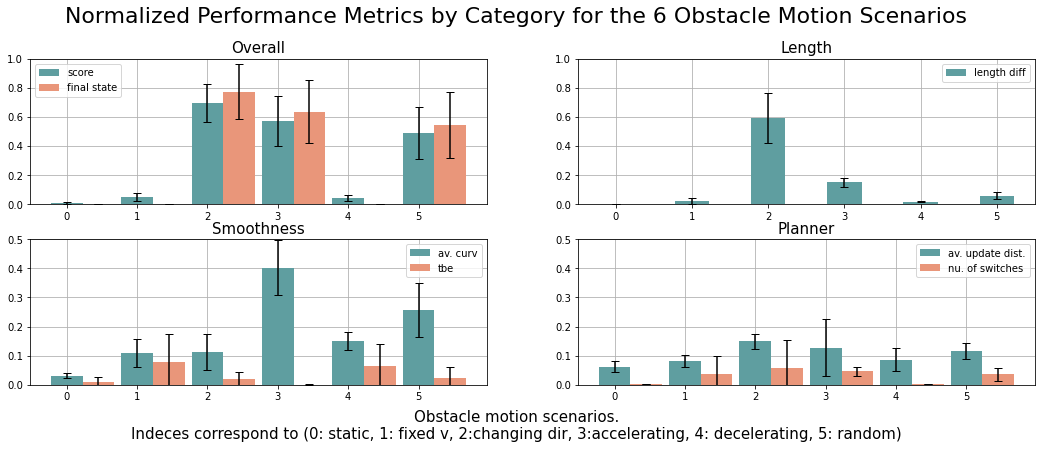

In [93]:
barWidth = 0.45

fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.grid(zorder=0)
ax2.grid(zorder=0)
ax3.grid(zorder=0)
ax4.grid(zorder=0)

df_t = df_obs.groupby(['O_M']).mean()

y_err_1 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'score_n']) for i in range(6)]
y_err_2_1 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'final_state_n']) for i in range(6)]
ax1.bar(df_t.index, df_t.score_n, width=barWidth, label="score", yerr=y_err_1, capsize=4, zorder=3, color="CadetBlue")
ax1.bar(df_t.index+barWidth, df_t.final_state_n, width=barWidth, label="final state", yerr=y_err_2_1, capsize=4, zorder=3, color="DarkSalmon")

y_err_2 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'length_diff_n']) for i in range(6)]
ax2.bar(df_t.index, df_t.length_diff_n, width=barWidth, label="length diff", yerr=y_err_2, capsize=4, zorder=3, color="CadetBlue")

y_err_3 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'av_curvature_n']) for i in range(6)]
y_err_3_1 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'tbe_n']) for i in range(6)]
ax3.bar(df_t.index, df_t.av_curvature_n, width=barWidth, label="av. curv", yerr=y_err_3, capsize=4, zorder=3, color="CadetBlue")
ax3.bar(df_t.index+barWidth, df_t.tbe_n, width=barWidth, label="tbe", yerr=y_err_3_1, capsize=4, zorder=3, color="DarkSalmon")

y_err_4 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'av_update_dist_n']) for i in range(6)]
y_err_4_1 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'n_switches_n']) for i in range(6)]
ax4.bar(df_t.index, df_t.av_update_dist_n, width=barWidth, label="av. update dist.", yerr=y_err_4, capsize=4, zorder=3, color="CadetBlue")
ax4.bar(df_t.index+barWidth, df_t.n_switches_n, width=barWidth, label="nu. of switches", yerr=y_err_4_1, capsize=4, zorder=3, color="DarkSalmon")


# ['static', 'fixed v', 'changing dir', 'accelerating', 'decelerating', 'random']

ax1.set_title("Overall", fontsize=15)
ax3.set_title("Smoothness", fontsize=15)
ax4.set_title("Planner", fontsize=15)
ax2.set_title("Length", fontsize=15)

ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,.5)
ax4.set_ylim(0,.5)

ax1.legend(loc=0)
ax2.legend(loc=1)
ax3.legend(loc=0)
ax4.legend(loc=0)

fig.text(0.5, -0.0, 'Obstacle motion scenarios.\nIndeces correspond to (0: static, 1: fixed v, 2:changing dir, 3:accelerating, 4: decelerating, 5: random)', ha='center', fontsize=15)
fig.suptitle("Normalized Performance Metrics by Category for the 6 Obstacle Motion Scenarios", fontsize=22, y = 1.0)
fig.subplots_adjust(hspace = 0.24) 
plt.show()

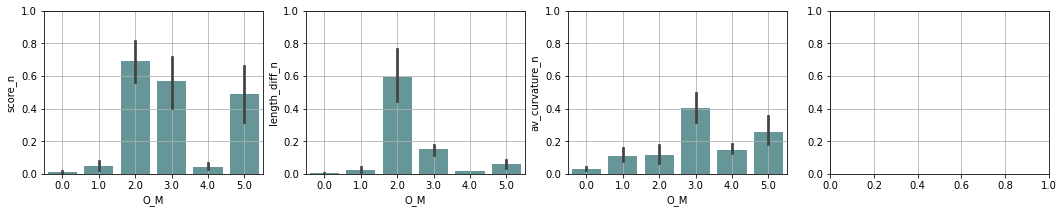

In [293]:
fig = plt.figure(figsize=(18,3))
ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

columns = ["O_M", "n_switches_n", "av_update_dist_n"]
df_melted = pd.melt(df_obs, id_vars=columns[0],\
                           var_name="source", value_name="value_numbers")


sns.barplot(x="O_M", y="score_n", data=df_obs, ax=ax1, color="CadetBlue")
sns.barplot(x="O_M", y="length_diff_n", data=df_obs, ax=ax2, color="CadetBlue")
sns.barplot(x="O_M", y="av_curvature_n", data=df_obs, ax=ax3, color="CadetBlue")

#sns.barplot(x=columns[0], y="value_numbers", hue="source",\
#                data=df_melted, ax=ax4)
#ax4 = sns.barplot(x="O_M", y="n_switches_n", data=df_obs, ax=ax4, color="CadetBlue", label="switches")
#sns.barplot(x="tmp", y="av_update_dist_n", data=df_obs_, ax=ax4, color="red", label="update dist")

ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,1)
ax4.set_ylim(0,1)

ax1.grid(zorder=0)
ax2.grid(zorder=0)
ax3.grid(zorder=0)
ax4.grid(zorder=0)

plt.show()

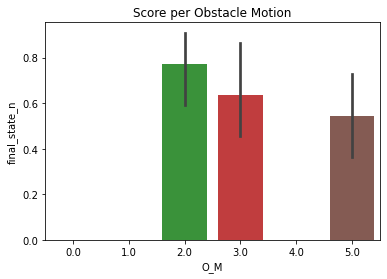

In [292]:

ax = sns.barplot(x="O_M", y="final_state_n", data=df_obs)
ax.set_title("Score per Obstacle Motion")
plt.show()

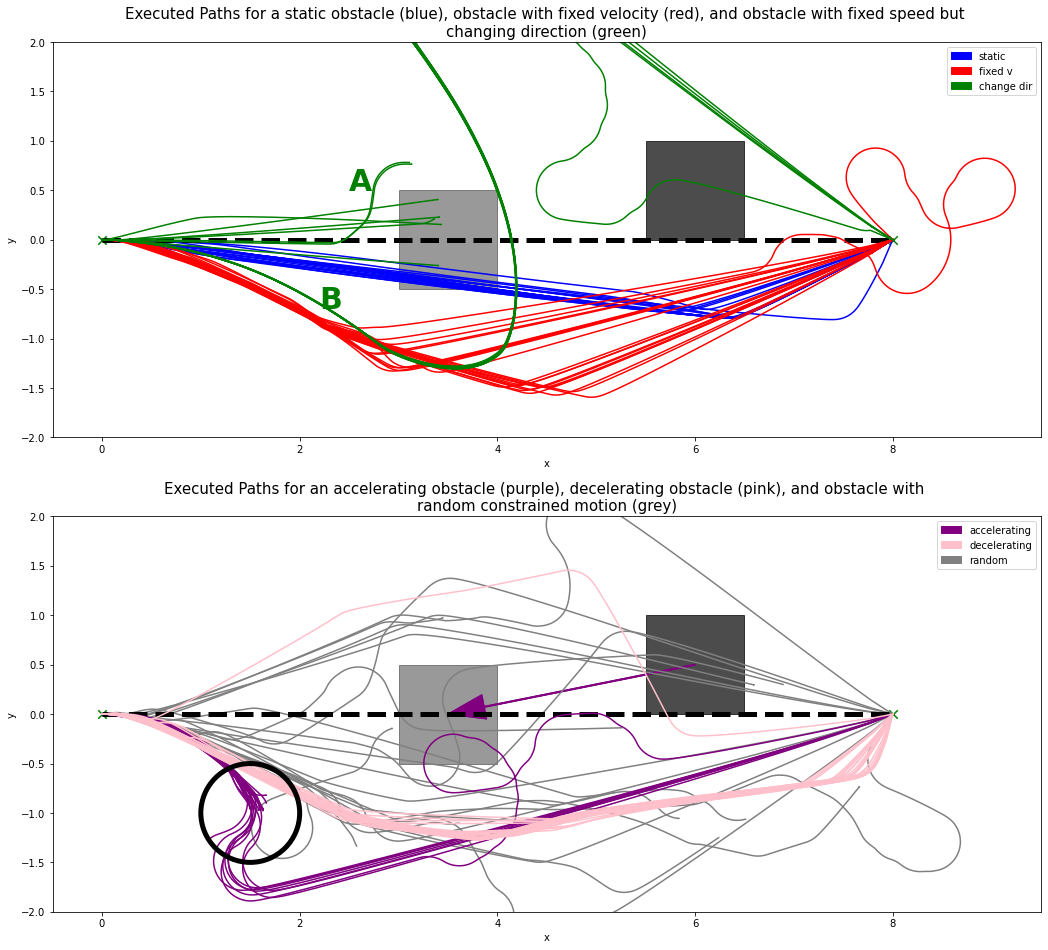

In [369]:
fig = plt.figure(figsize=(20,16))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 0), 'path_all'], ax=ax1, col="blue")
plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 1), 'path_all'], ax=ax1, col="red", only_paths=True)
plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 2), 'path_all'], ax=ax1, col="green", only_paths=True)

plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 5), 'path_all'], ax=ax2, col="grey")
plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 3), 'path_all'], ax=ax2, col="purple", only_paths=True)
plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 4), 'path_all'], ax=ax2, col="pink", only_paths=True)

patch_0 = mpatches.Patch(color="blue", label='static')
patch_1 = mpatches.Patch(color="red", label='fixed v')
patch_2 = mpatches.Patch(color="green", label='change dir')

patch_3 = mpatches.Patch(color="purple", label='accelerating')
patch_4 = mpatches.Patch(color="pink", label='decelerating')
patch_5 = mpatches.Patch(color="grey", label='random')

circle = plt.Circle((1.5, -1), 0.5, linewidth=5, color='black', fill=False, zorder=5)
ax2.add_artist(circle)
ax1.text(2.5, 0.5, "A", fontsize=30, fontdict ={'fontweight':'bold', 'color':'green'})
ax1.text(2.2, -0.7, "B", fontsize=30, fontdict ={'fontweight':'bold', 'color':'green'})

ax1.set_ylim(-2,2)
ax1.set_xlim(-.5,9.5)

ax2.set_ylim(-2,2)
ax2.set_xlim(-.5,9.5)

ax1.legend(handles=[patch_0, patch_1, patch_2])
ax2.legend(handles=[patch_3, patch_4, patch_5])

ax1.set_title("Executed Paths for a static obstacle (blue), obstacle with fixed velocity (red), and obstacle with fixed speed but \nchanging direction (green)", fontsize=15)
ax2.set_title("Executed Paths for an accelerating obstacle (purple), decelerating obstacle (pink), and obstacle with \nrandom constrained motion (grey)", fontsize=15)

plt.show()

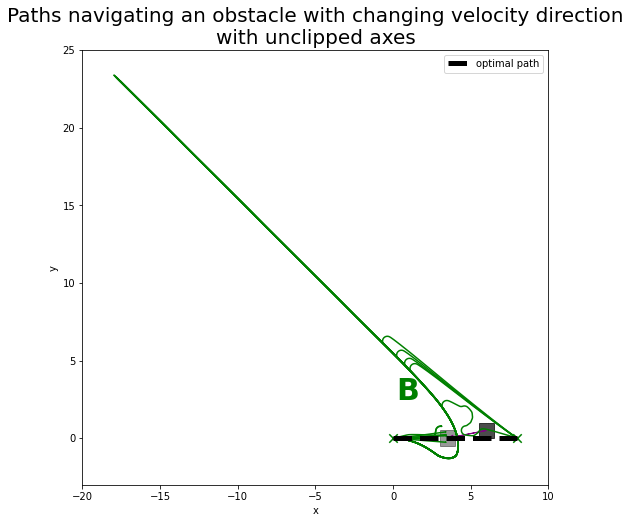

In [372]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(111)

plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 2), 'path_all'], ax=ax1, col="green")

ax1.set_ylim(-3,25)
ax1.set_xlim(-20,10)

ax1.text(0.2, 2.5, "B", fontsize=30, fontdict ={'fontweight':'bold', 'color':'green'})

ax1.set_title("Paths navigating an obstacle with changing velocity direction\nwith unclipped axes", fontsize=20)
plt.show()

In [158]:
df_obs.loc[((df_obs['O_M'] == 3) | (df_obs['O_M'] == 4)) & (df_obs['length'] > 25.)]

,scenario,iteration,O_M,final_state,path_all,path_update,length,length_diff,av_update_dist,n_switches,prop_suc_updates,av_curvature,tbe,length_diff_n,av_update_dist_n,prop_suc_updates_n,av_curvature_n,n_switches_n,tbe_n,score
15,7,2,3.0,2.0,"[[0.0, -0.0005465197010438691, 0.0006382604766...","[[-17.90752089055429, 23.327958537313517, 0.0,...",38.065324,30.065324,0.016699,0.0,1.000000,0.004413,1485.906105,0.990913,0.327510,1.000000,0.172548,0.000000,0.000318,5.327510
16,7,2,4.0,2.0,"[[0.0, -0.0005465197010438691, -0.000547179468...","[[-13.24567106929057, 18.78593146296586, 0.0, ...",37.956975,29.956975,0.015114,59.0,0.985367,0.007408,2203.521018,0.987323,0.289882,0.946494,0.339761,0.066218,0.000472,5.304515
33,7,5,3.0,2.0,"[[0.0, -0.0005465197010438691, 0.0010597479968...","[[-18.08761766945904, 23.50709186798156, 0.0, ...",38.033829,30.033829,0.015795,0.0,1.000000,0.002697,851.650634,0.989869,0.306037,1.000000,0.076807,0.000000,0.000182,5.306037
39,7,6,3.0,2.0,"[[0.0, -0.0005465197010438691, 0.0010594880782...","[[-18.006832989153597, 23.409657613177668, 0.0...",37.826681,29.826681,0.016879,0.0,1.000000,0.002852,857.639855,0.983007,0.331790,1.000000,0.085425,0.000000,0.000183,5.331790
45,7,7,3.0,2.0,"[[0.0, -0.0005465197010438691, 0.0010600077516...","[[-17.93491811270874, 23.3337589905371, 0.0, m...",37.822146,29.822146,0.016319,0.0,1.000000,0.002704,808.259670,0.982856,0.318502,1.000000,0.077162,0.000000,0.000172,5.318502
46,7,7,4.0,2.0,"[[0.0, -0.0005465197010438691, -0.000547047435...","[[-12.151710496909109, 18.47880387983628, 0.0,...",37.677416,29.677416,0.013951,0.0,1.000000,0.003966,1194.809357,0.978061,0.262237,1.000000,0.147609,0.000000,0.000255,5.262237
69,7,11,3.0,2.0,"[[0.0, -0.0005463878666927547, 0.0010600077516...","[[-18.109789402590547, 23.513063124895766, 0.0...",37.957027,29.957027,0.016892,0.0,1.000000,0.002781,829.752443,0.987325,0.332095,1.000000,0.081457,0.000000,0.000177,5.332095
87,7,14,3.0,2.0,"[[0.0, -0.0005465197010438691, 0.0010603970771...","[[-17.959195073719055, 23.38406371360009, 0.0,...",38.052998,30.052998,0.015927,0.0,1.000000,0.002678,839.188269,0.990505,0.309184,1.000000,0.075727,0.000000,0.000179,5.309184
111,7,18,3.0,2.0,"[[0.0, -0.0005465197010438691, 0.0010600077516...","[[-17.935251203295124, 23.35843570849549, 0.0,...",38.119024,30.119024,0.016766,0.0,1.000000,0.002863,874.180293,0.992692,0.329122,1.000000,0.086054,0.000000,0.000186,5.329122
129,7,21,3.0,2.0,"[[0.0, -0.0005465197010438691, 0.0010600077516...","[[-18.020519604389445, 23.41854651154721, 0.0,...",38.339607,30.339607,0.016656,0.0,1.000000,0.004301,1360.335632,1.000000,0.326503,1.000000,0.166315,0.000000,0.000291,5.326503


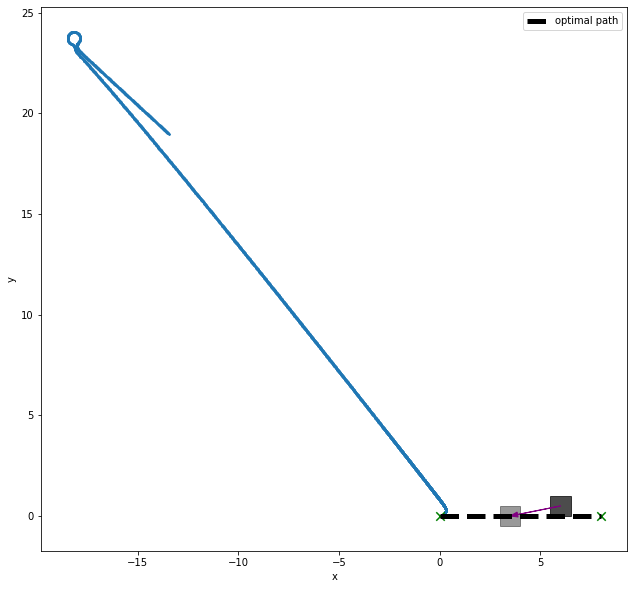

In [144]:

plot_updates(scenarios_d[7], [df_obs.loc[(df_obs['O_M'] == 3) & (df_obs['length'] > 38.), 'path_update'][129]], size=(20,10))
plt.show()

[[0.0,
  -0.0005465197010438691,
  0.001059747996843612,
  0.009429554188096633,
  0.016990802831677566,
  0.02567372478289341,
  0.03347351451180555,
  0.041738019333111144,
  0.048247491632069664,
  0.05597305504003487,
  0.06326327909060155,
  0.07051032678107791,
  0.07808933184657067,
  0.0857400030863905,
  0.09317724917373253,
  0.09938612754972251,
  0.1048100041291511,
  0.11171618421742976,
  0.1185772534832626,
  0.1249843248131082,
  0.13168637855996154,
  0.1390246284789983,
  0.14587565127679208,
  0.15296764576139762,
  0.15925413739520924,
  0.16548359449446814,
  0.1715941077544473,
  0.17827065486747218,
  0.18347541520802485,
  0.18982890325179122,
  0.19547358187139077,
  0.20098967169422535,
  0.2060654375817217,
  0.21103866362340526,
  0.2158792594316774,
  0.22060719476453047,
  0.2255081791198189,
  0.23050908435390066,
  0.23407752239219967,
  0.2393337087934092,
  0.244369567083123,
  0.24824183571517147,
  0.25177686929276255,
  0.2550416096973791,
  0.25823

In [153]:
df_obs.iloc[32].path_update[-1]

[-17.915025018228057, 23.334055987581813, 0.0, 'bf', 1]

In [154]:
df_obs.iloc[33].path_update[0]

[-18.08761766945904, 23.50709186798156, 0.0, 'mtg', 1]

In [157]:
df_obs.iloc[33].path_all[0][0], df_obs.iloc[33].path_all[1][0]

(0.0, 0.0)

In [147]:
df_obs.iloc[0].path_update

[[-0.0005470474352465878, -1.1312722112871373e-05, 0.0, 'mtg', 1],
 [-0.0005470474352465878, -1.1312722112871373e-05, 0.0, 'mtg', 1],
 [-0.0005477079990896461, -1.1309903344756036e-05, 0.0, 'mtg', 1],
 [0.0007755775886031546, -1.591297756655094e-05, 0.0, 'mtg', 1],
 [0.0007755775886031546, -1.591297756655094e-05, 0.0, 'mtg', 1],
 [0.0007755775886031546, -1.591297756655094e-05, 0.0, 'mtg', 1],
 [0.0007755775886031546, -1.591297756655094e-05, 0.0, 'mtg', 1],
 [0.005929131018524314, -2.2885873195286038e-05, 0.0, 'mtg', 1],
 [0.005929131018524314, -2.2885873195286038e-05, 0.0, 'mtg', 1],
 [0.005929131018524314, -2.2885873195286038e-05, 0.0, 'mtg', 1],
 [0.005929131018524314, -2.2885873195286038e-05, 0.0, 'mtg', 1],
 [0.011089446222877495, -5.5867728654792013e-05, 0.0, 'mtg', 1],
 [0.011089446222877495, -5.5867728654792013e-05, 0.0, 'mtg', 1],
 [0.011089446222877495, -5.5867728654792013e-05, 0.0, 'mtg', 1],
 [0.011089446222877495, -5.5867728654792013e-05, 0.0, 'mtg', 1],
 [0.016227943483230

## Plot Paths

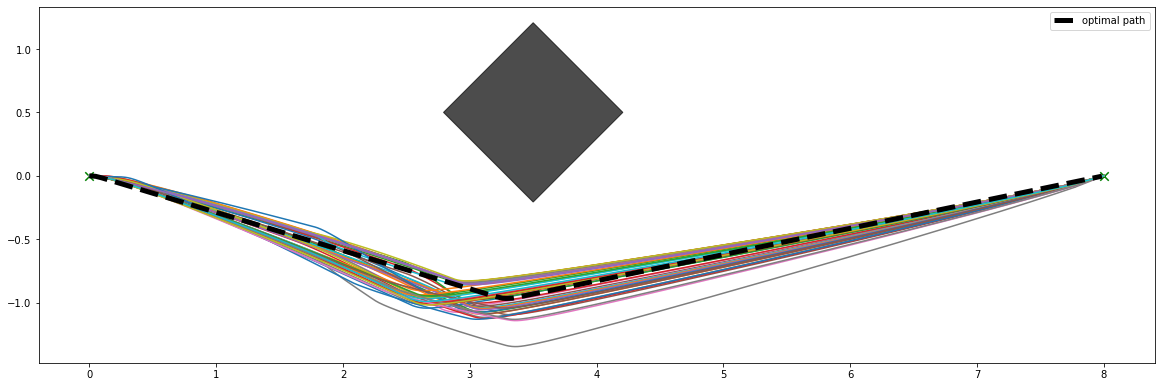

In [343]:
plot_scenario(scenarios_d[1], df_s_1["path_all"], size=(20, 10))

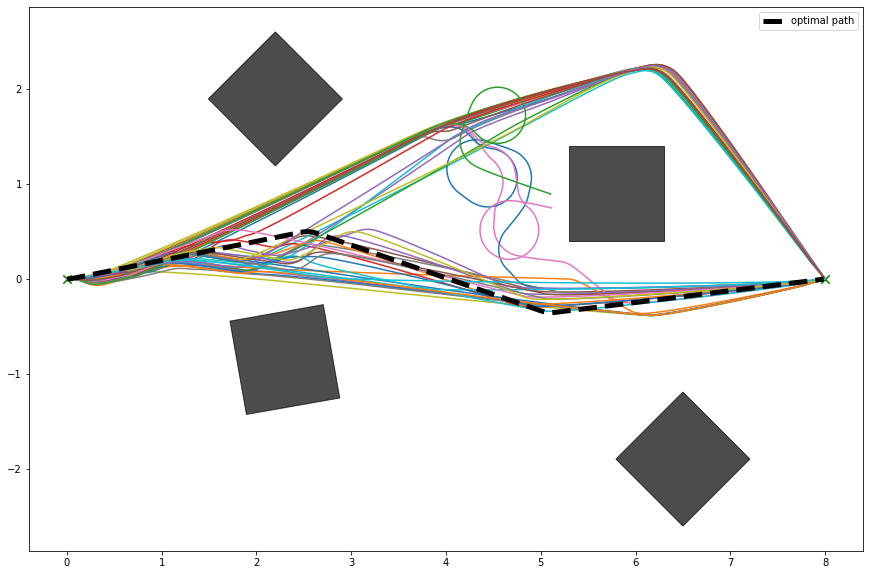

In [346]:
plot_scenario(scenarios_d[2], df_s_2["path_all"], size=(20, 10))

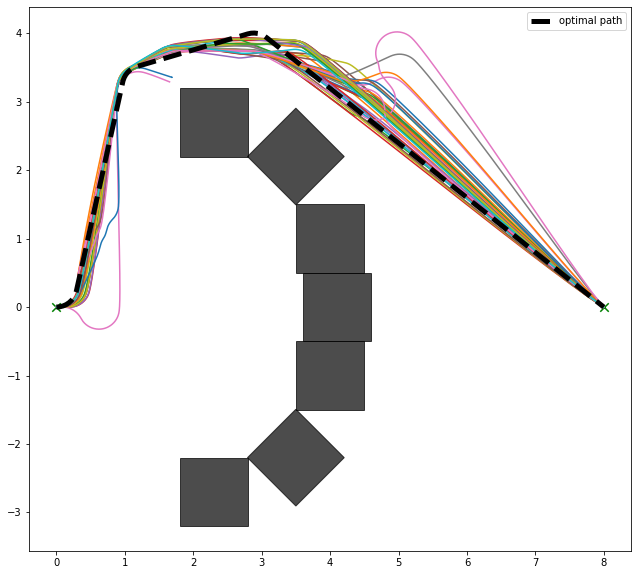

In [347]:
plot_scenario(scenarios_d[3], df_s_3["path_all"], size=(20, 10))

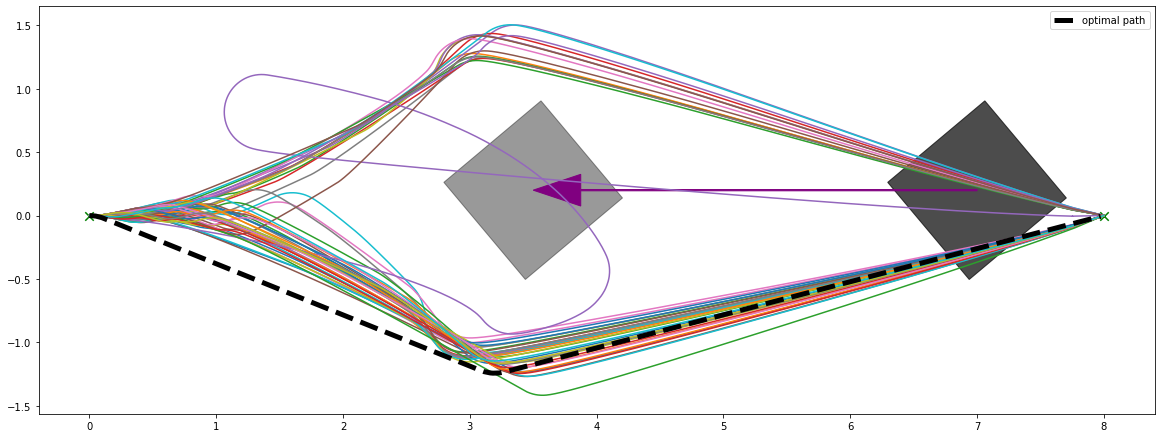

In [348]:
plot_scenario(scenarios_d[4], df_s_4["path_all"], size=(20, 10))

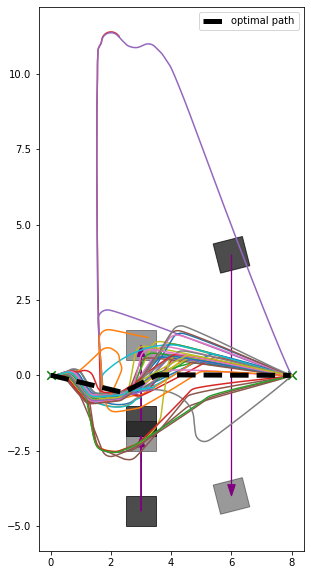

In [349]:
plot_scenario(scenarios_d[5], df_s_5["path_all"], size=(20, 10))

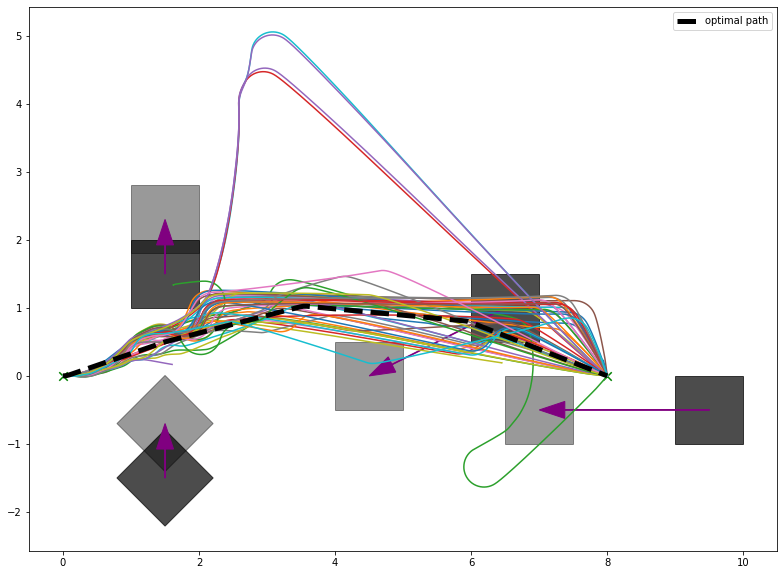

In [351]:
#plot_scenario(scenarios_d[6], df_s_6.loc[(df['final_state'] == 2) & (df['iteration'] == 1)]["path_all"], size=(20, 10))
plot_scenario(scenarios_d[6], df_s_6["path_all"], size=(20, 10))

In [360]:
#df_s_6.loc[(df['final_state'] == 2) & (df['iteration'] == 0)]
df_s_6.loc[(df['final_state'] == 1)]

,scenario,iteration,H_TOL,D_TOL,final_state,path_all,path_mtg,path_bf,length,length_diff_to_optimal,mean_update_dist,beh_switches,av_curvature
250,6,0,0.0,0.0,1.0,"[[0.0, -0.00013321273641584926, -0.00013370908...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.05156751664894966, -7.544113736717251e-05,...",8.523944,0.523944,0.042305,52.0,None
251,6,0,0.0,0.2,1.0,"[[0.0, -0.00013321273641584926, -0.00013360980...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.05156751664894966, -7.544113736717251e-05,...",8.475684,0.475684,0.043596,52.0,None
252,6,0,0.0,0.4,1.0,"[[0.0, -0.00013321273641584926, -0.00013360980...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.05156751664894966, -7.544113736717251e-05,...",12.738350,4.738350,0.045109,52.0,None
253,6,0,0.0,0.6,1.0,"[[0.0, -0.00013321273641584926, -0.00013360980...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.05156751664894966, -7.544113736717251e-05,...",8.383770,0.383770,0.046233,52.0,None
255,6,0,0.2,0.0,1.0,"[[0.0, -0.00013321273641584926, -0.00013370908...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.05156751664894966, -7.544113736717251e-05,...",8.360264,0.360264,0.052507,52.0,None
256,6,0,0.2,0.2,1.0,"[[0.0, -0.00013311348064829872, -0.00013360980...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.05156751664894966, -7.544113736717251e-05,...",8.495670,0.495670,0.052985,52.0,None
257,6,0,0.2,0.4,1.0,"[[0.0, -0.00013321273641584926, -0.00013360980...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.05156751664894966, -7.544113736717251e-05,...",8.937587,0.937587,0.053369,52.0,None
259,6,0,0.2,0.8,1.0,"[[0.0, -0.00013321273641584926, -0.00013360980...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.05156751664894966, -7.544113736717251e-05,...",13.744847,5.744847,0.053939,52.0,None
260,6,0,0.4,0.0,1.0,"[[0.0, -0.00013311348064829872, -0.00013360980...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.0408953375058375, -6.0875671173033643e-05,...",8.820417,0.820417,0.005162,6.0,None
261,6,0,0.4,0.2,1.0,"[[0.0, -0.00013321273641584926, 0.001620214827...","[[-0.00013360980127489255, -2.9929303951833e-0...","[[0.05156751664894966, -7.544113736717251e-05,...",8.837381,0.837381,0.074339,52.0,None


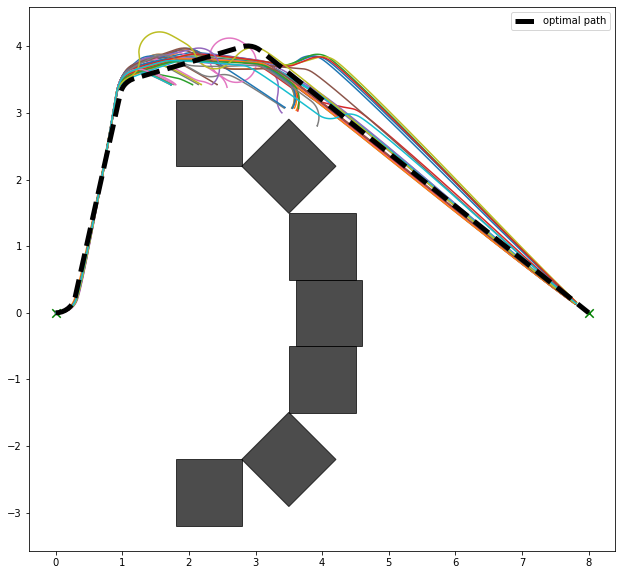

In [101]:
plot_scenario(scenarios_d[3], df_s_3["path_all"], size=(20, 10))

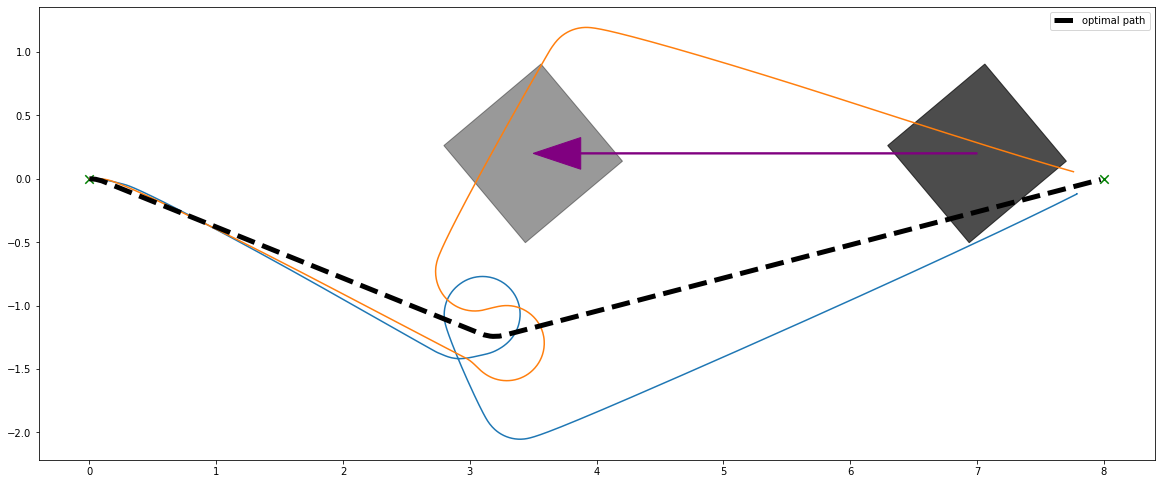

In [187]:
plot_scenario(scenarios_d[4], df_s_4.loc[(df['H_TOL'] == '0.8') & (df['D_TOL'] == '0.2')]["path_all"], size=(20, 10))

# Experiment Resolution

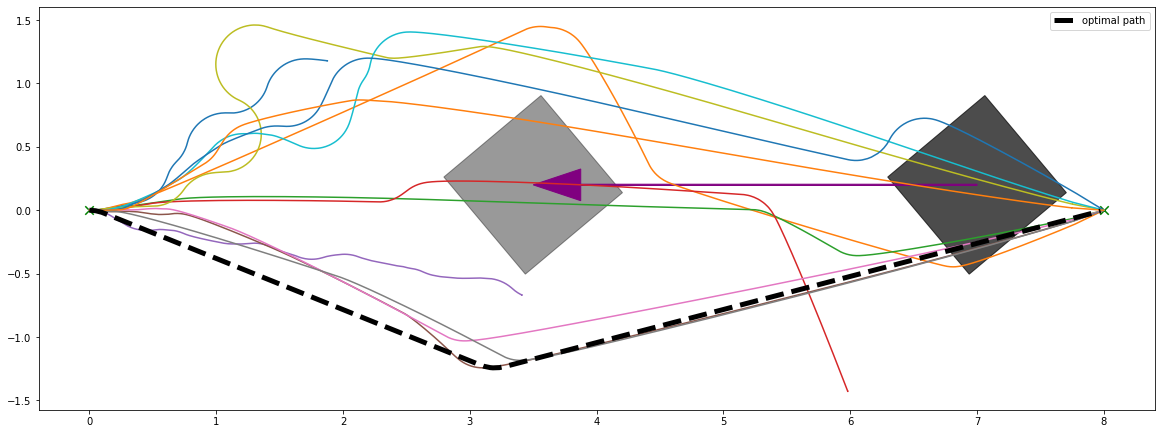

In [22]:
plot_scenario(scenarios_d[4], df_res["path_all"], size=(20, 10))

# Performance Experiments

In [19]:
base_dir = "exp_data\\"
f_name = str(base_dir) + "perf.csv"
df_perf = pd.DataFrame(columns=["language", "presorting", "caching", "early_exit", "intersecting", "total_time"])
with open(f_name, newline='') as csvfile:
    csvReader = csv.reader(csvfile, delimiter=';')
    for j, row in enumerate(csvReader):
        if j != 0:
            df_perf = df_perf.append({
                        "language": row[0],
                        "presorting":  bool(int(row[1])),
                        "caching": bool(int(row[2])),
                        "early_exit": bool(int(row[3])),
                        "intersecting": bool(int(row[4])),
                        "total_time": float(row[5]) 
                        }, ignore_index=True)

In [28]:
def assign_label(row):
    if row["presorting"] and not row["caching"] and not row["early_exit"]:
        return "presorting"
    if row["caching"] and not row["presorting"] and not row["early_exit"]:
        return "caching"
    if row["presorting"] and row["early_exit"] and not row["caching"]:
        return "presorting and\nearly exit"
    if row["presorting"] and row["caching"] and row["early_exit"]:
        return "all"
    return "none"
        
df_perf["optimisation"] = df_perf.apply(lambda row: assign_label(row), axis=1)

df_perf

,language,presorting,caching,early_exit,intersecting,total_time,optimisation
0,Pure python,False,False,False,True,73.26,none
1,Pure python,False,False,False,False,116.58,none
2,Pure python,True,False,False,True,3.15,presorting
3,Pure python,True,False,False,False,119.28,presorting
4,Pure python,True,False,True,True,3.23,presorting and\nearly exit
5,Pure python,True,False,True,False,3.02,presorting and\nearly exit
6,Pure python,False,True,False,True,66.63,caching
7,Pure python,False,True,False,False,104.35,caching
8,Python with cython backend,False,False,False,True,70.31,none
9,Python with cython backend,False,False,False,False,97.30,none


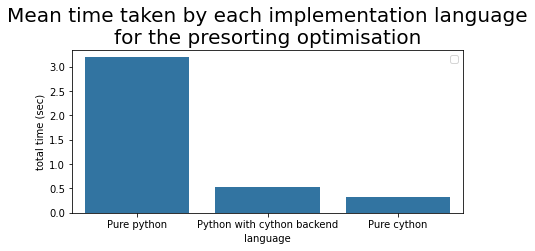

In [49]:
fig = plt.figure(figsize=(7, 3))
ax1 = plt.subplot(111)

sns.barplot(x="language", y="total_time", hue="intersecting", data=df_perf.loc[(df_perf['presorting'] == True) & (df_perf['intersecting'] == True)], ci=None, ax=ax1)

ax1.set_title("Mean time taken by each implementation language\nfor the presorting optimisation", fontsize=20)
ax1.set_ylabel("total time (sec)")
ax1.legend([])
plt.show()

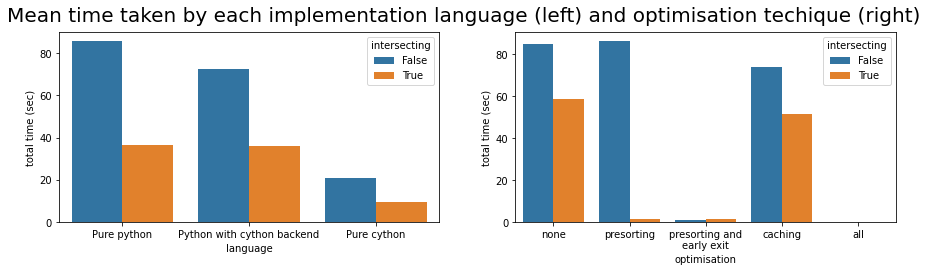

In [39]:
fig = plt.figure(figsize=(15, 3.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

sns.barplot(x="language", y="total_time", hue="intersecting", data=df_perf, ci=None, ax=ax1)
sns.barplot(x="optimisation", y="total_time", hue="intersecting", data=df_perf, ci=None, ax=ax2)

#ax1.set_title("Mean time taken by each implementation language", fontsize=20)
#ax2.set_title("Mean time taken by each optimisation techique", fontsize=20)
fig.suptitle("Mean time taken by each implementation language (left) and optimisation techique (right)", fontsize=20)


ax1.set_ylabel("total time (sec)")
ax2.set_ylabel("total time (sec)")

plt.show()